In [1]:
""" Get action histograms of generated JSON user-split datasets. """

import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import os.path as osp
import json
import matplotlib.pyplot as plt
import pickle

# Print all variables on their own lines
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', 1000)


In [2]:
ds_jsons={
'TRAIN_SPLIT':'/home/matthiasdelange/sftp_remote_projects/ContextualOracle_Matthias/forecasting/continual_ego4d/usersplit_data/2022-08-09_16-02-54_ego4d_LTA_usersplit/ego4d_LTA_train_usersplit_10users.json'
,'TEST_SPLIT': '/home/matthiasdelange/sftp_remote_projects/ContextualOracle_Matthias/forecasting/continual_ego4d/usersplit_data/2022-08-09_16-02-54_ego4d_LTA_usersplit/ego4d_LTA_test_usersplit_40users.json'
,'PRETRAIN_SPLIT': '/home/matthiasdelange/sftp_remote_projects/ContextualOracle_Matthias/forecasting/continual_ego4d/usersplit_data/2022-08-09_16-02-54_ego4d_LTA_usersplit/ego4d_LTA_pretrain_incl_nanusers_usersplit_148users.json'
}


In [3]:
# Load JSON action sets
# -user_action_sets
#   - user_agnostic
#     - verb_to_name_dict: {'name': "ACTION_NAME", 'count': "ACTION_COUNT"}
#     - noun_to_name_dict: {'name': "ACTION_NAME", 'count': "ACTION_COUNT"}
#     - action_to_name_dict: {'name': "ACTION_NAME", 'count': "ACTION_COUNT"}

def add_to_all(cntr_dict, all_dict):
    for action,cnt in cntr_dict.items():
        all_dict['ALL'][action] += cnt

ds_counts_actions = {'ALL':defaultdict(int)}
ds_counts_verbs = {'ALL':defaultdict(int)}
ds_counts_nouns = {'ALL':defaultdict(int)}
for name, json_filepath in ds_jsons.items():
    with open(json_filepath, 'r') as f:
        json_obj = json.load(f)
        
    parent_dicts = json_obj['user_action_sets']['user_agnostic']
    
    # Get counts per action
    action_cntr = {k:namecnt_dict['count'] for k, namecnt_dict in parent_dicts['action_to_name_dict'].items()}
    verb_cntr = {k:namecnt_dict['count'] for k, namecnt_dict in parent_dicts['verb_to_name_dict'].items()}
    noun_cntr = {k:namecnt_dict['count'] for k, namecnt_dict in parent_dicts['noun_to_name_dict'].items()}  
    
    
    ds_counts_actions[name] = action_cntr
    add_to_all(action_cntr, ds_counts_actions)
    ds_counts_verbs[name] = verb_cntr
    add_to_all(verb_cntr, ds_counts_verbs)
    ds_counts_nouns[name] = noun_cntr
    add_to_all(noun_cntr, ds_counts_nouns)
ds_counts_actions.keys()
ds_counts_actions

dict_keys(['ALL', 'TRAIN_SPLIT', 'TEST_SPLIT', 'PRETRAIN_SPLIT'])

{'ALL': defaultdict(int,
             {'99-362': 4,
              '92-399': 37,
              '72-362': 2,
              '9-399': 4,
              '65-399': 23,
              '100-150': 79,
              '92-265': 81,
              '112-265': 15,
              '65-265': 68,
              '100-106': 2,
              '11-129': 51,
              '65-182': 6,
              '92-389': 89,
              '9-362': 5,
              '101-150': 59,
              '99-150': 43,
              '108-362': 3,
              '1-362': 1,
              '49-150': 3,
              '49-362': 1,
              '98-265': 5,
              '92-326': 5,
              '9-326': 3,
              '49-326': 9,
              '65-389': 97,
              '98-389': 3,
              '65-326': 12,
              '108-389': 54,
              '86-389': 23,
              '50-59': 63,
              '67-326': 2,
              '11-59': 40,
              '0-150': 20,
              '27-326': 2,
              '72-326': 1,
              

In [4]:
# Convert counter dicts to lists
# Take the ALL as ordering, and add 0-counts for actions not seen in other sets
for ds_count_dict in [ds_counts_actions, ds_counts_verbs,ds_counts_nouns]:
    ordered_list = sorted([(name, cnt) for name,cnt in ds_count_dict['ALL'].items()], key=lambda x:x[1],reverse=True)
    ds_count_dict['ALL_ordered']={
        'name': [x[0] for x in ordered_list],
        'count': [x[1] for x in ordered_list],
    }
    
    # Add zero counts in dictionaries for TRAIN/TEST/PRETRAIN
    ds_count_dict_names = list(ds_count_dict.keys())
    for name in ds_count_dict_names:
        cntr_dict = ds_count_dict[name]
        if 'ALL' in name: 
            continue
        
        new_action_names = ds_count_dict['ALL_ordered']['name'] # Same as ALL
        new_action_counts = [0]* len(new_action_names)
        
        # Iterate split dict and add counts
        for order_idx, action_name in enumerate(new_action_names):
            if action_name in cntr_dict:
                count = cntr_dict[action_name]
                new_action_counts[order_idx] +=count
        
        ds_count_dict[f"{name}_ordered"] = {
        'name': new_action_names,
        'count': new_action_counts,
        }
#         print(f"Added {name}_ordered with cnts {new_action_counts} ")
        
ds_counts_actions.keys()


dict_keys(['ALL', 'TRAIN_SPLIT', 'TEST_SPLIT', 'PRETRAIN_SPLIT', 'ALL_ordered', 'TRAIN_SPLIT_ordered', 'TEST_SPLIT_ordered', 'PRETRAIN_SPLIT_ordered'])

In [5]:
def plot_barchart(x_axis: list[list], y_vals: list[list], title, ylabel, xlabel, y_labels=None, x_labels=None,
                  legend_labels=None,
                  grid=False, yerror: list[list] = None, bar_align='edge', bar_colors=None,
                  figsize=(12, 6), log=False, interactive=False, x_minor_ticks=None, output_file=None):
    max_val = max(el for y_l in y_vals for el in y_l)
    my_cmap = plt.get_cmap("plasma")
    fig = plt.figure(figsize=figsize, dpi=600)  # So all bars are visible!
    ax = plt.subplot()

    for plot_idx, (x, y) in enumerate(zip(x_axis, y_vals)):
        plot_yerror = None if yerror is None else yerror[plot_idx]
        bar_color = my_cmap.colors if bar_colors is None else bar_colors[plot_idx]
        legend_label = None if legend_labels is None else legend_labels[plot_idx]
        plt.bar(x, height=y, yerr=plot_yerror, label=legend_label,
                color=bar_color, align=bar_align, width=0.9, log=log)

    if legend_labels is not None:
        plt.legend()

    if x_minor_ticks is not None:
        #         ax.set_xticks(major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)

    # And a corresponding grid
    #         ax.grid(which='both')

    #         # Or if you want different settings for the grids:
    #         ax.grid(which='minor', alpha=0.2)
    #         ax.grid(which='major', alpha=0.5)

    if x_labels:
        plt.xticks(x_axis, x_labels, rotation='vertical')
    if y_labels:
        plt.yticks(y_vals, y_labels)

    plt.ylim(None, max_val * 1.01)
    plt.xlim(None, None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(grid, which='both')

    # Save
    if output_file is not None:
        fig.savefig(output_file, bbox_inches='tight')
        print(f"Saved plot: {output_file}")

    plt.show()
    plt.clf()

Skipping ALL mode
Skipping TRAIN_SPLIT mode
Skipping TEST_SPLIT mode
Skipping PRETRAIN_SPLIT mode


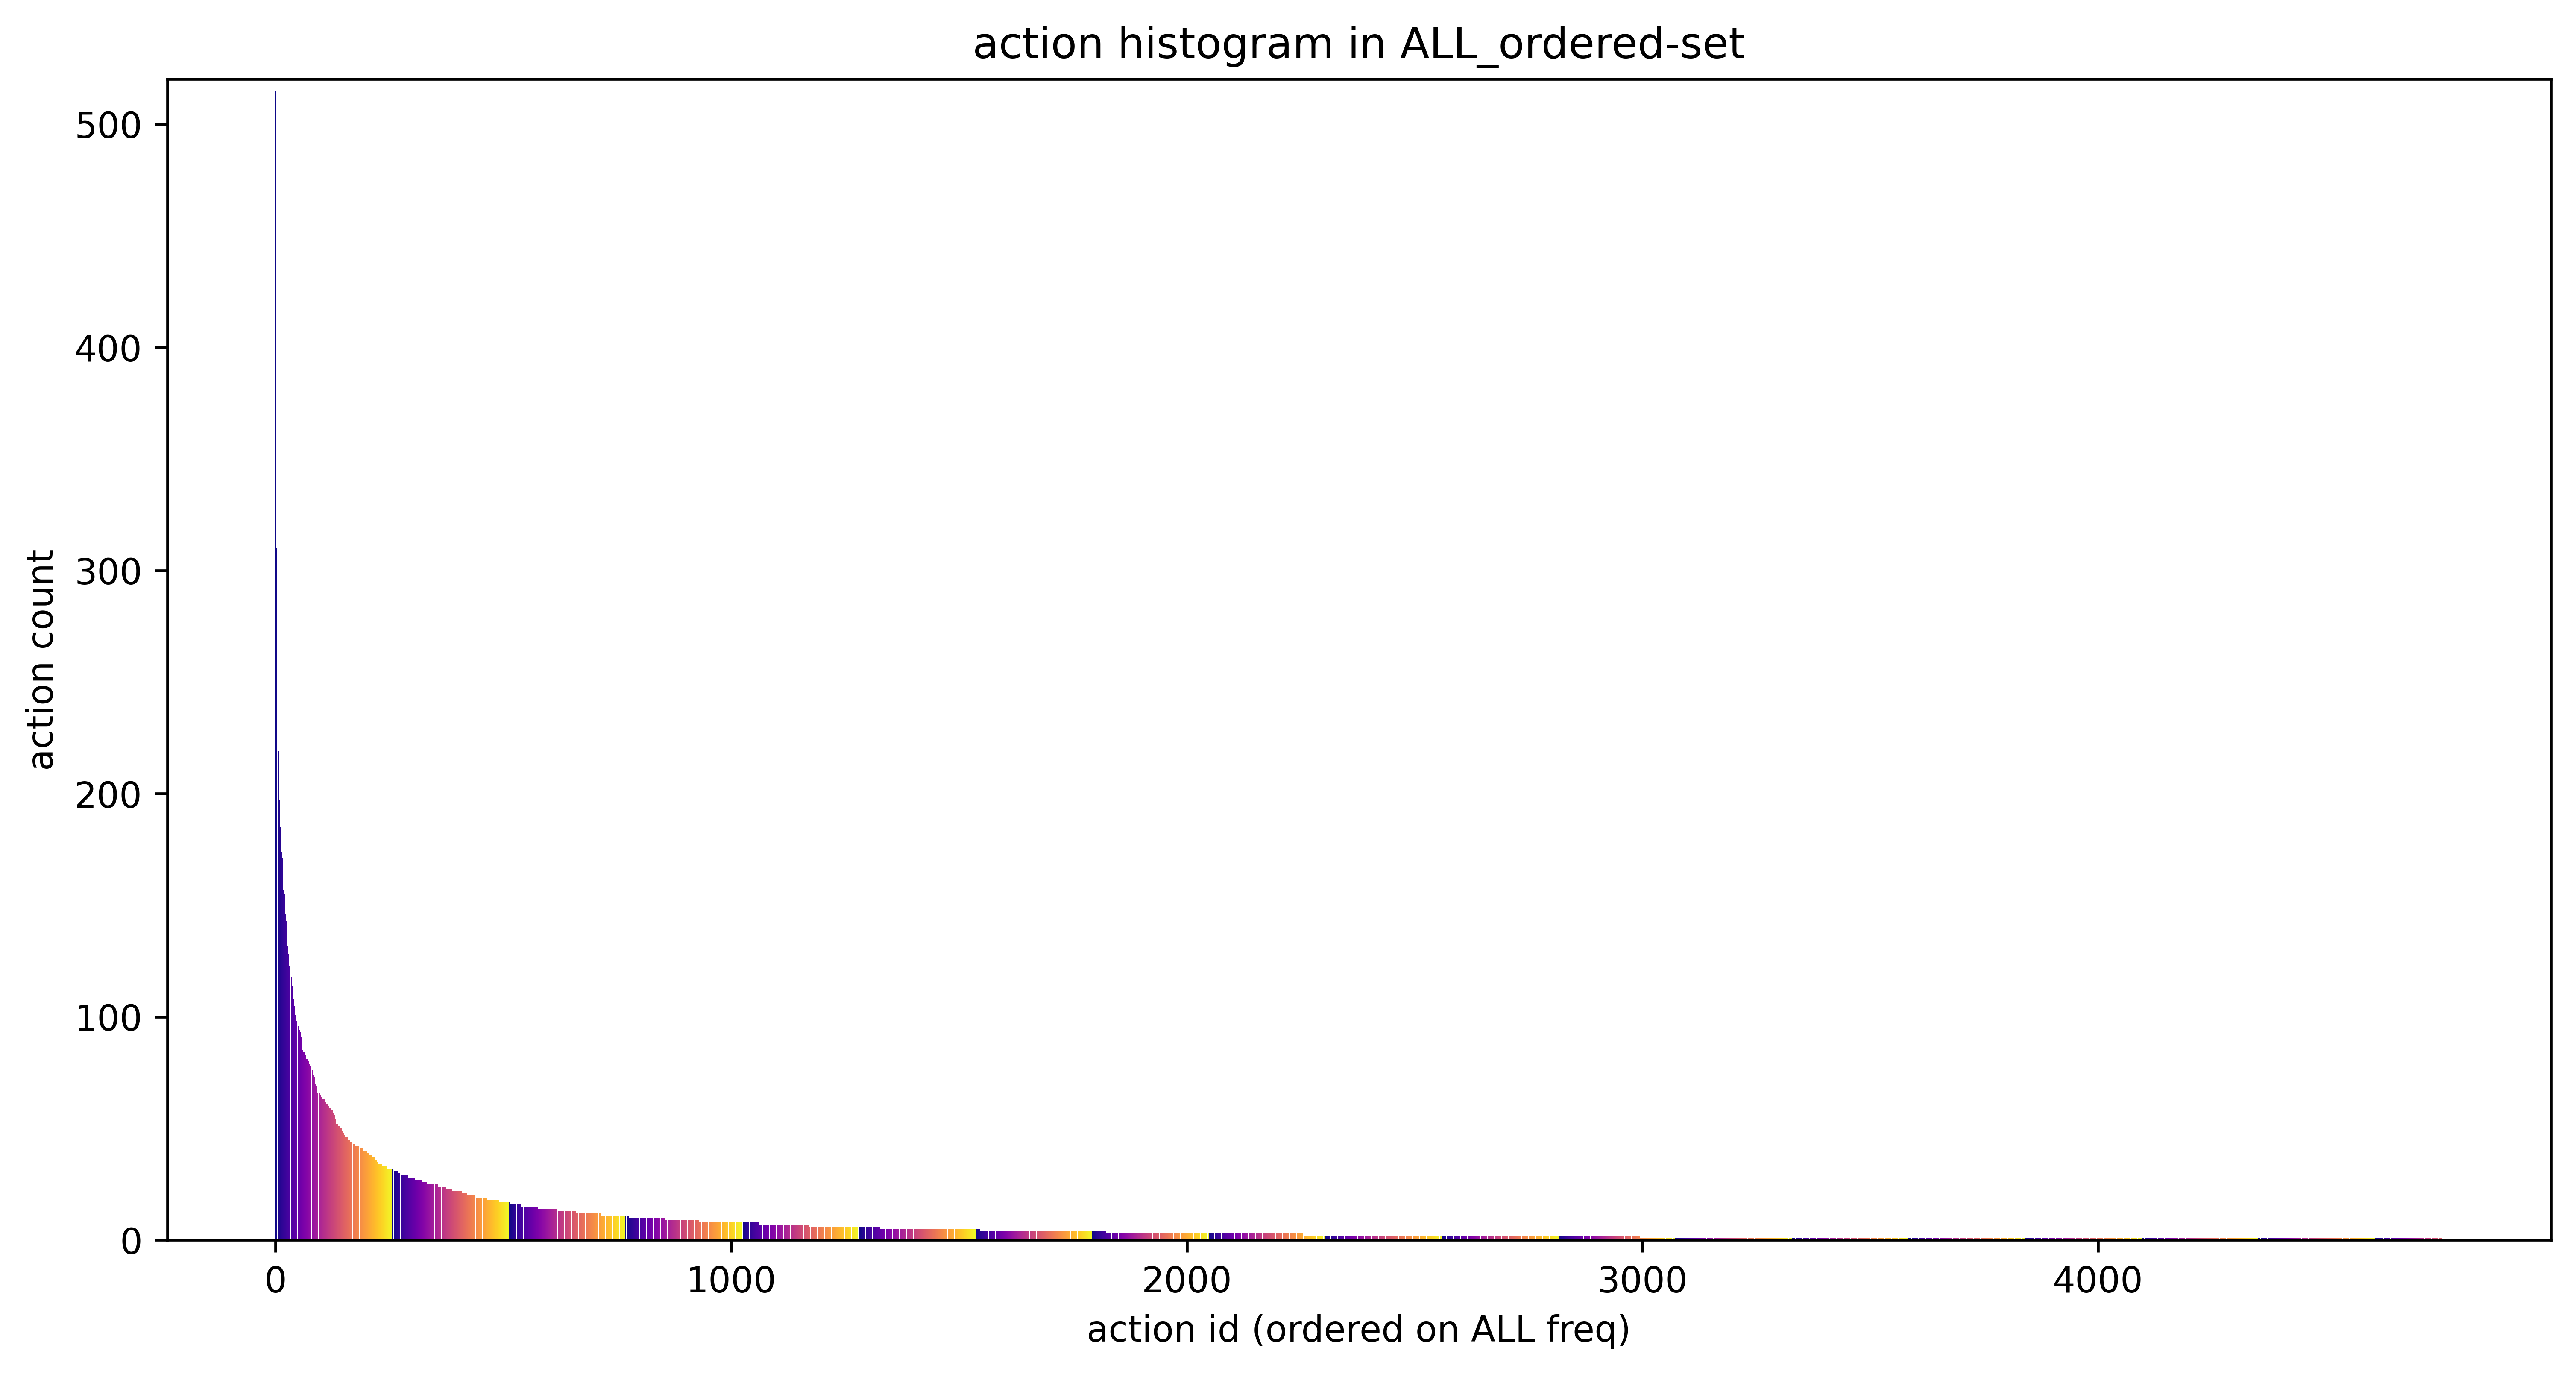

<Figure size 432x288 with 0 Axes>

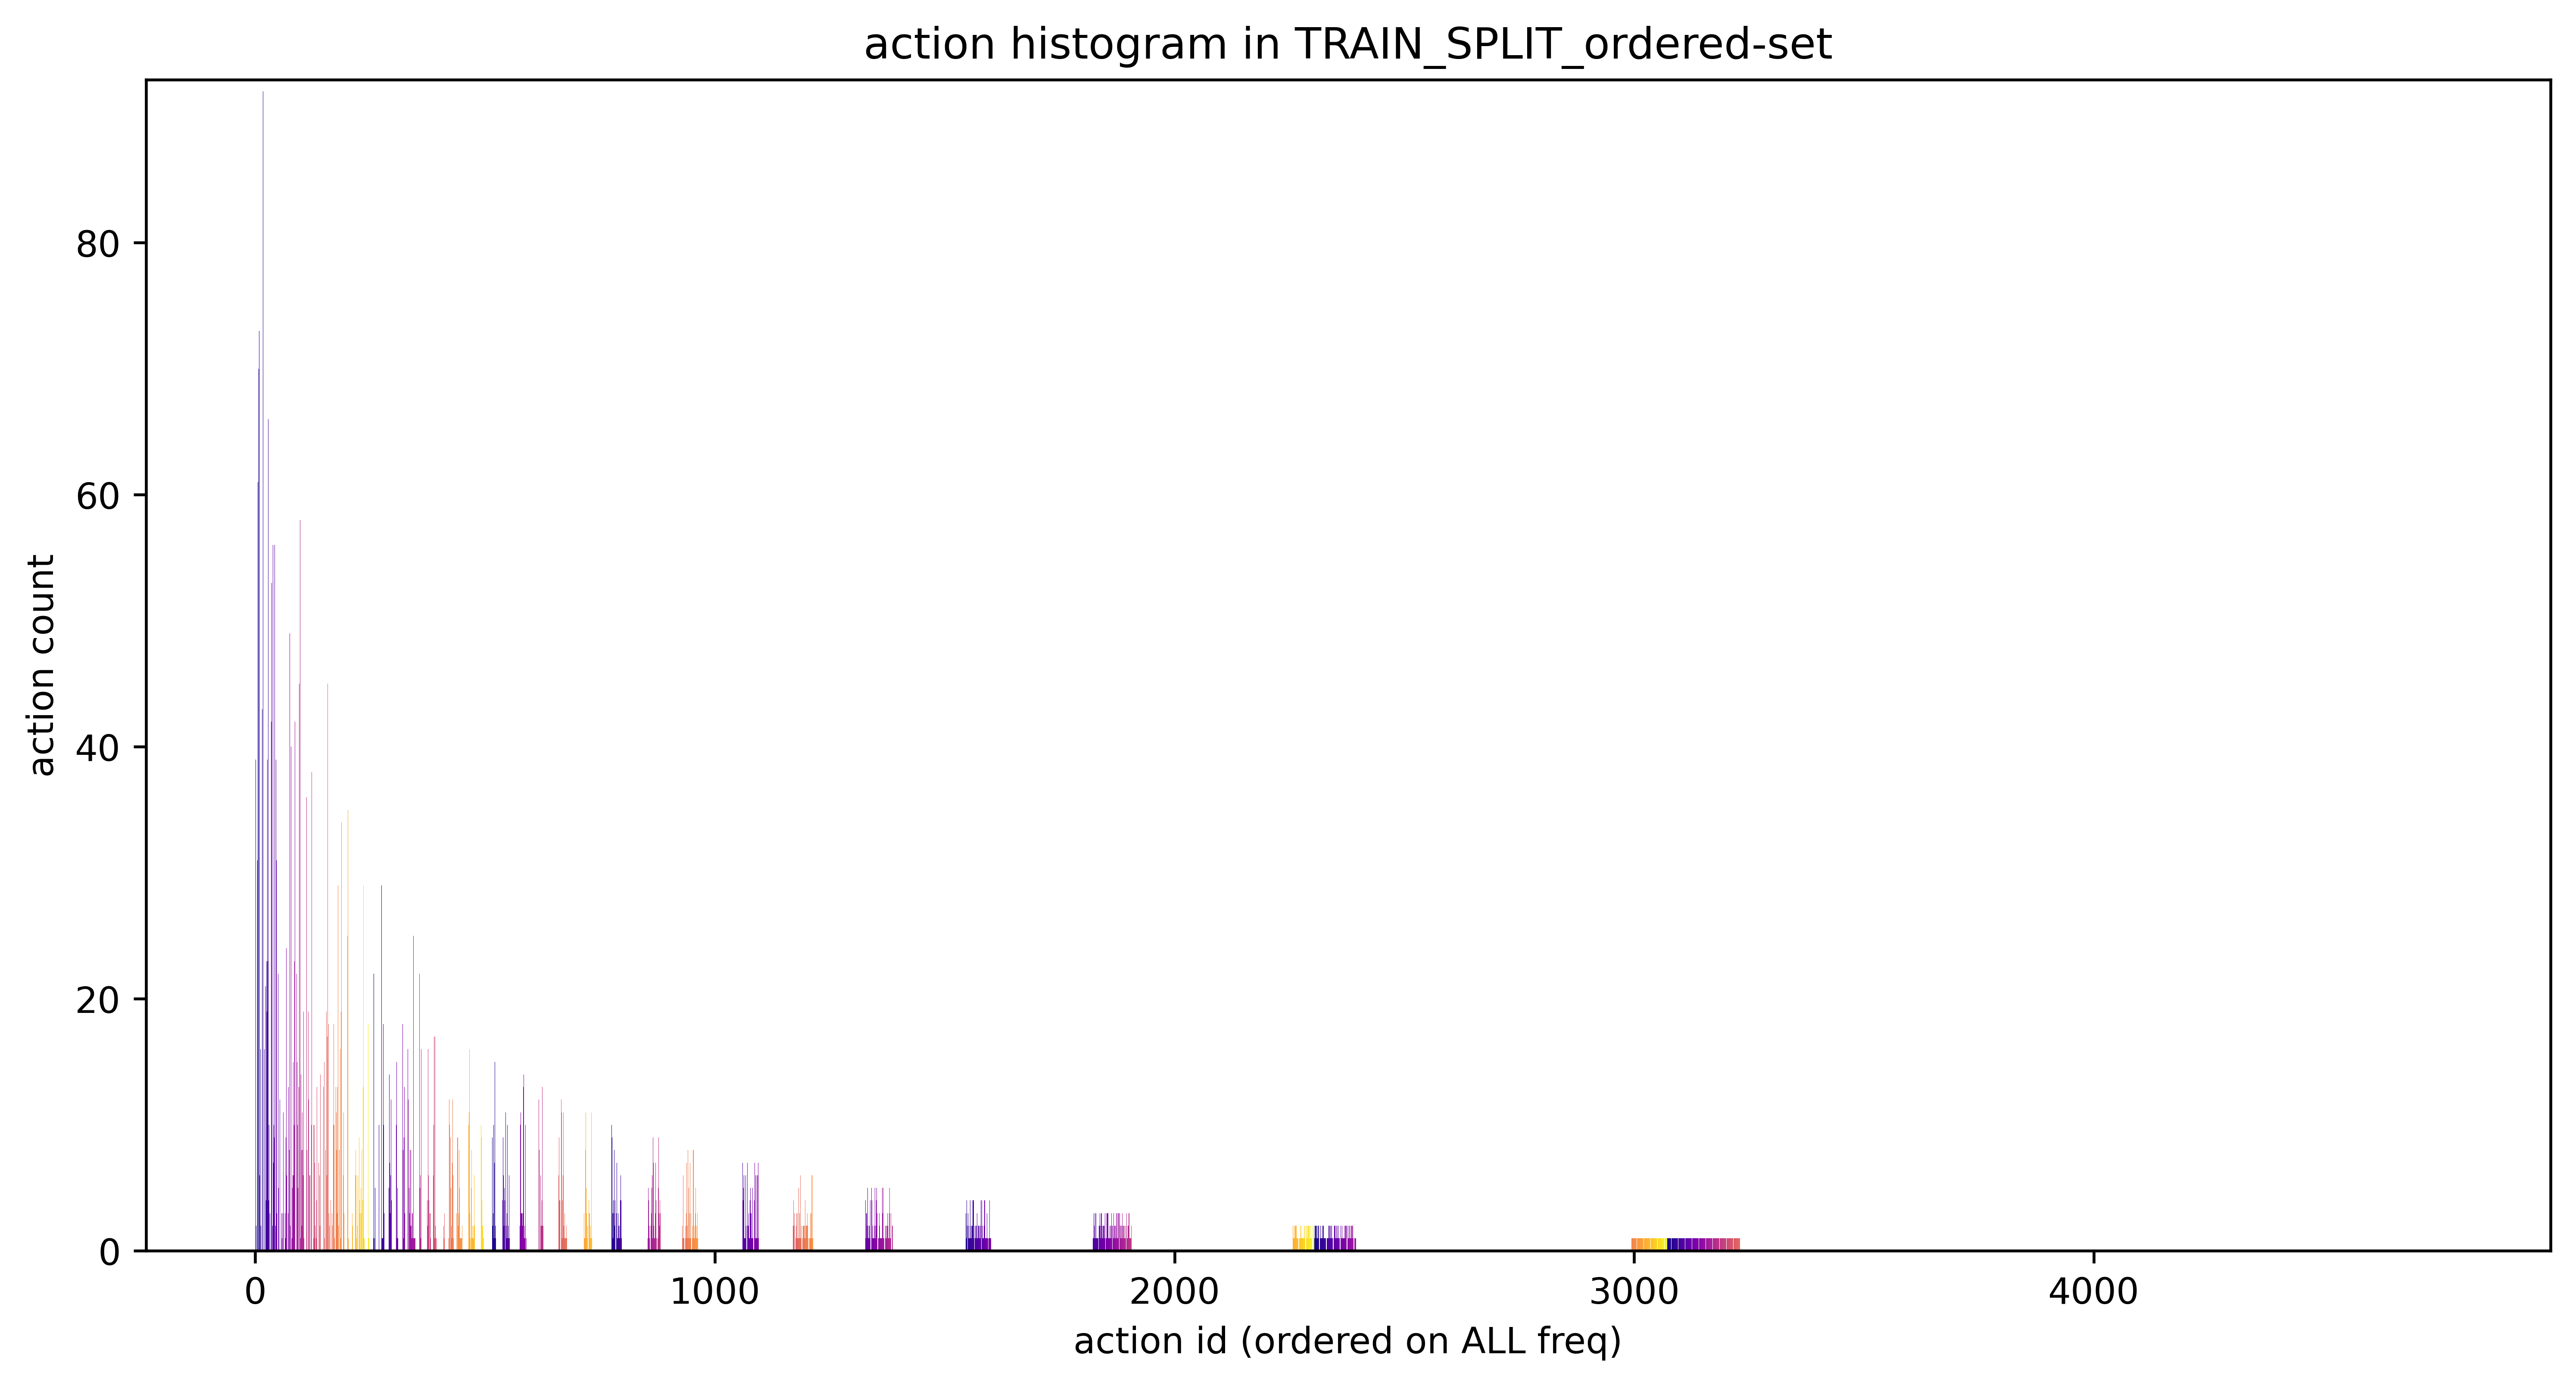

<Figure size 432x288 with 0 Axes>

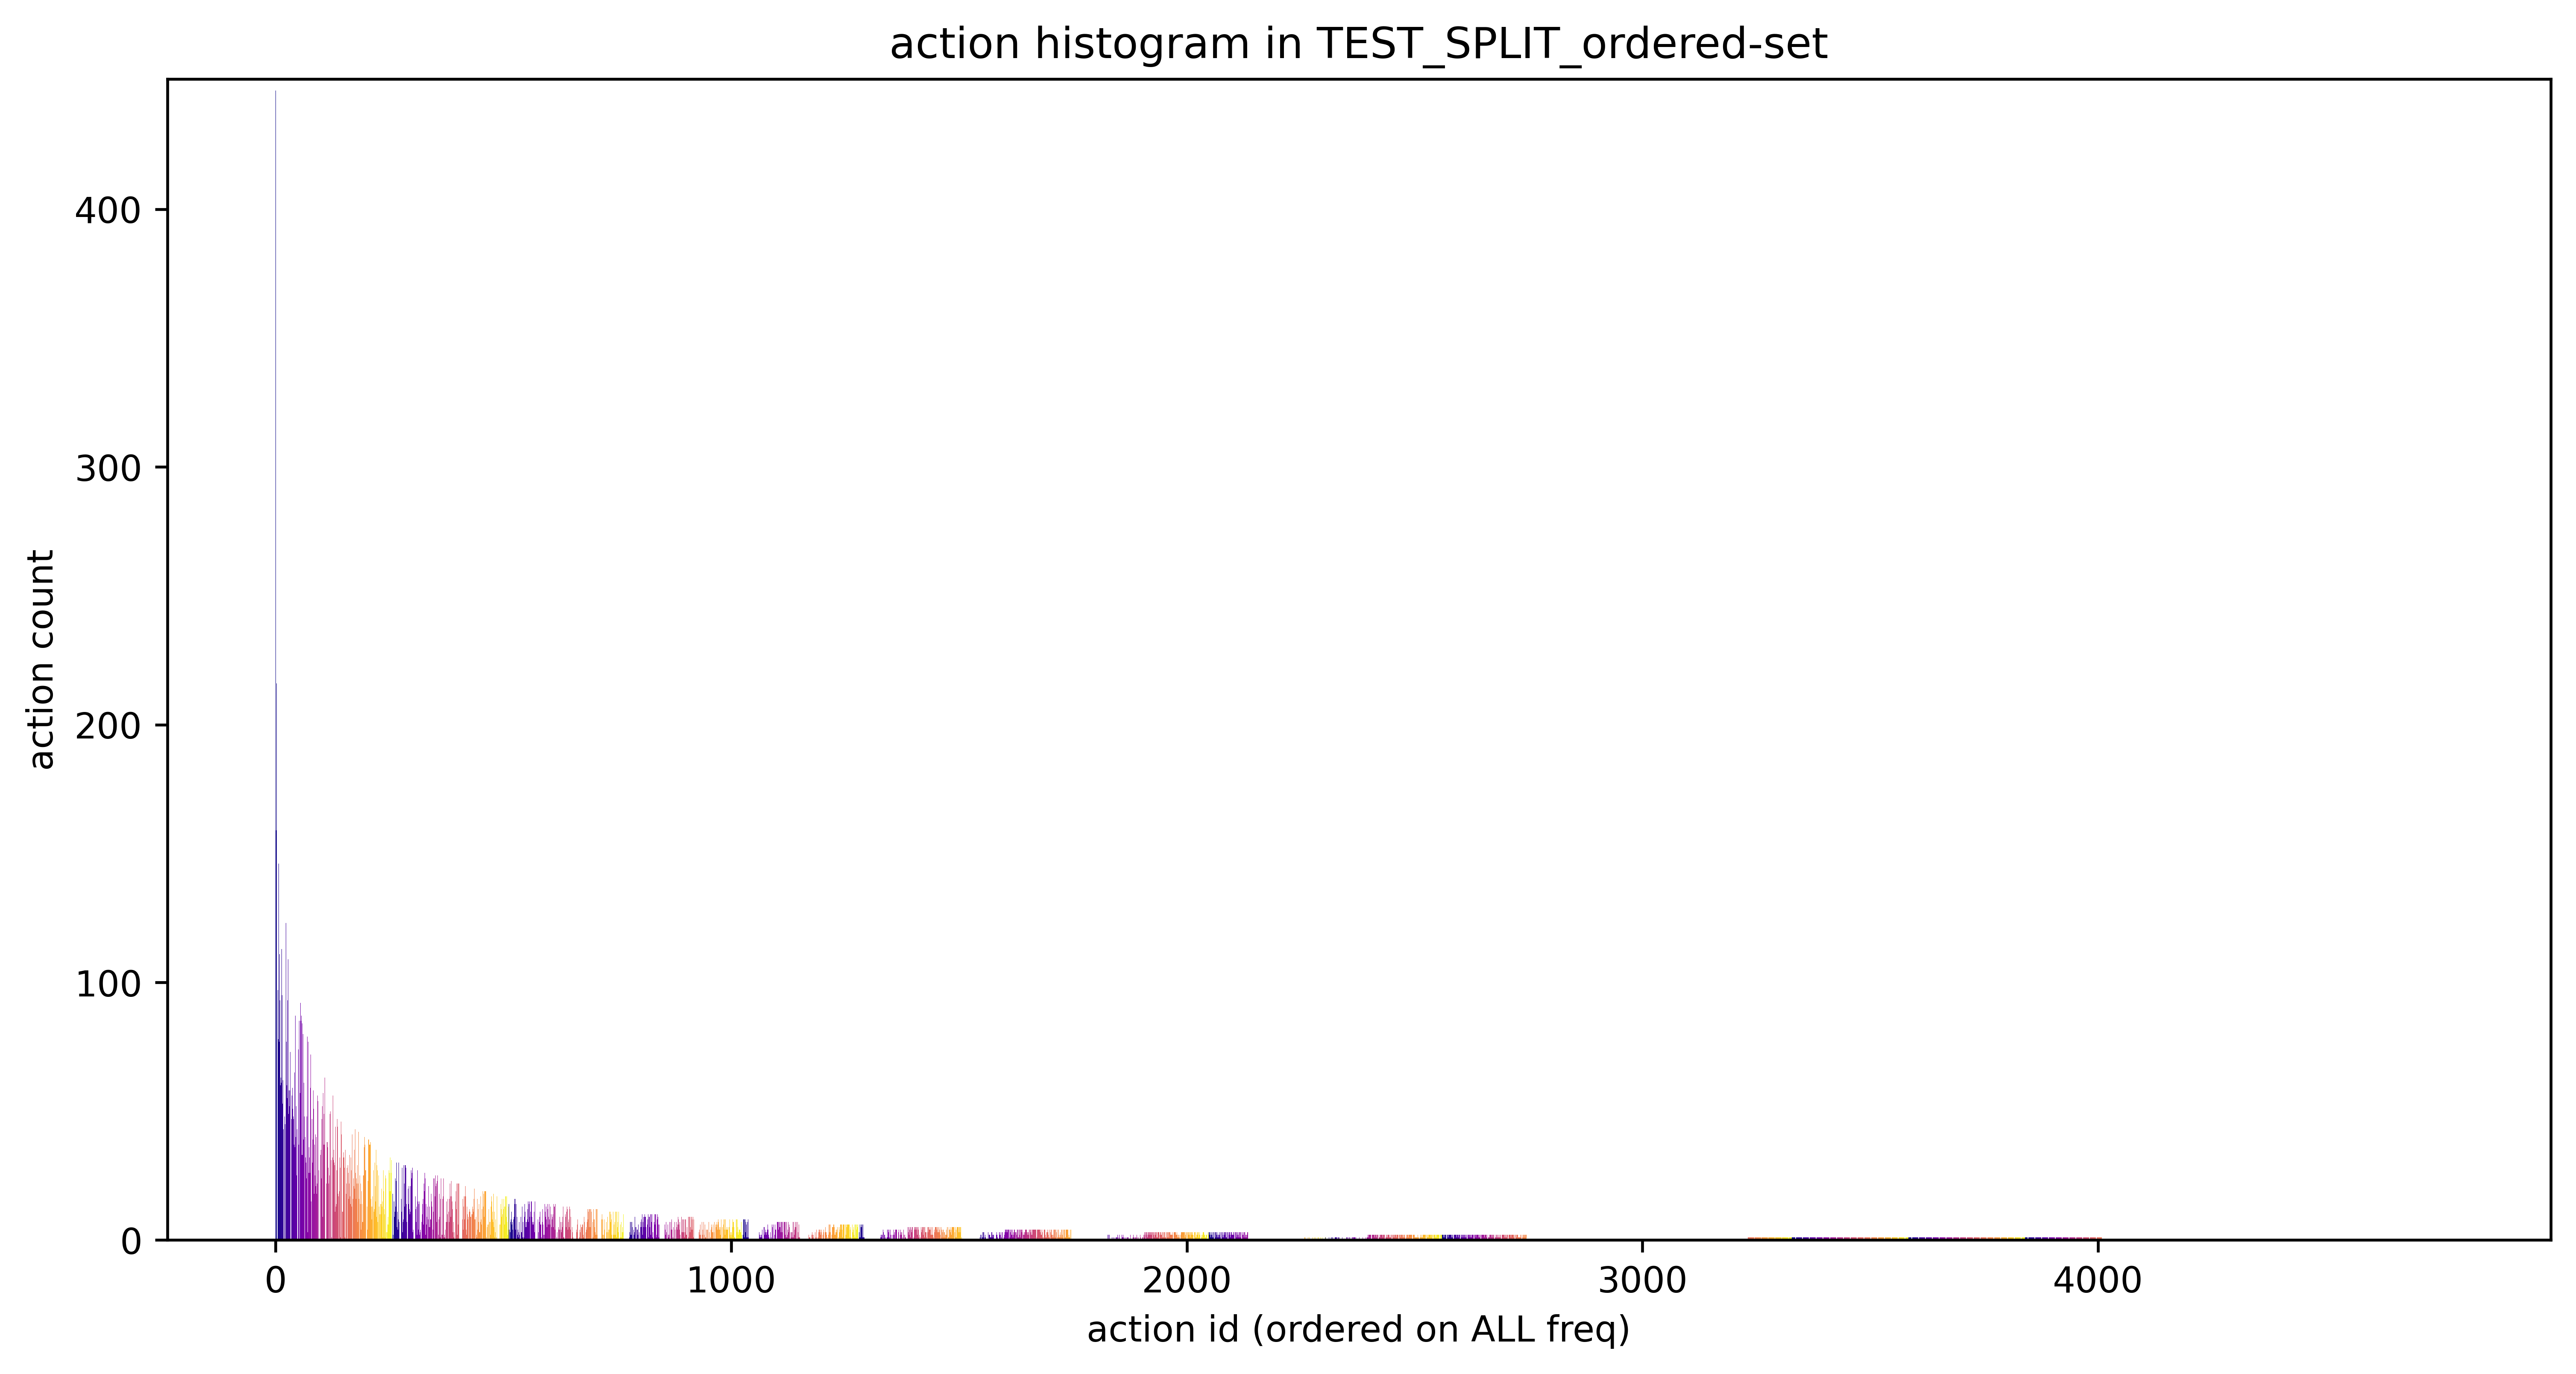

<Figure size 432x288 with 0 Axes>

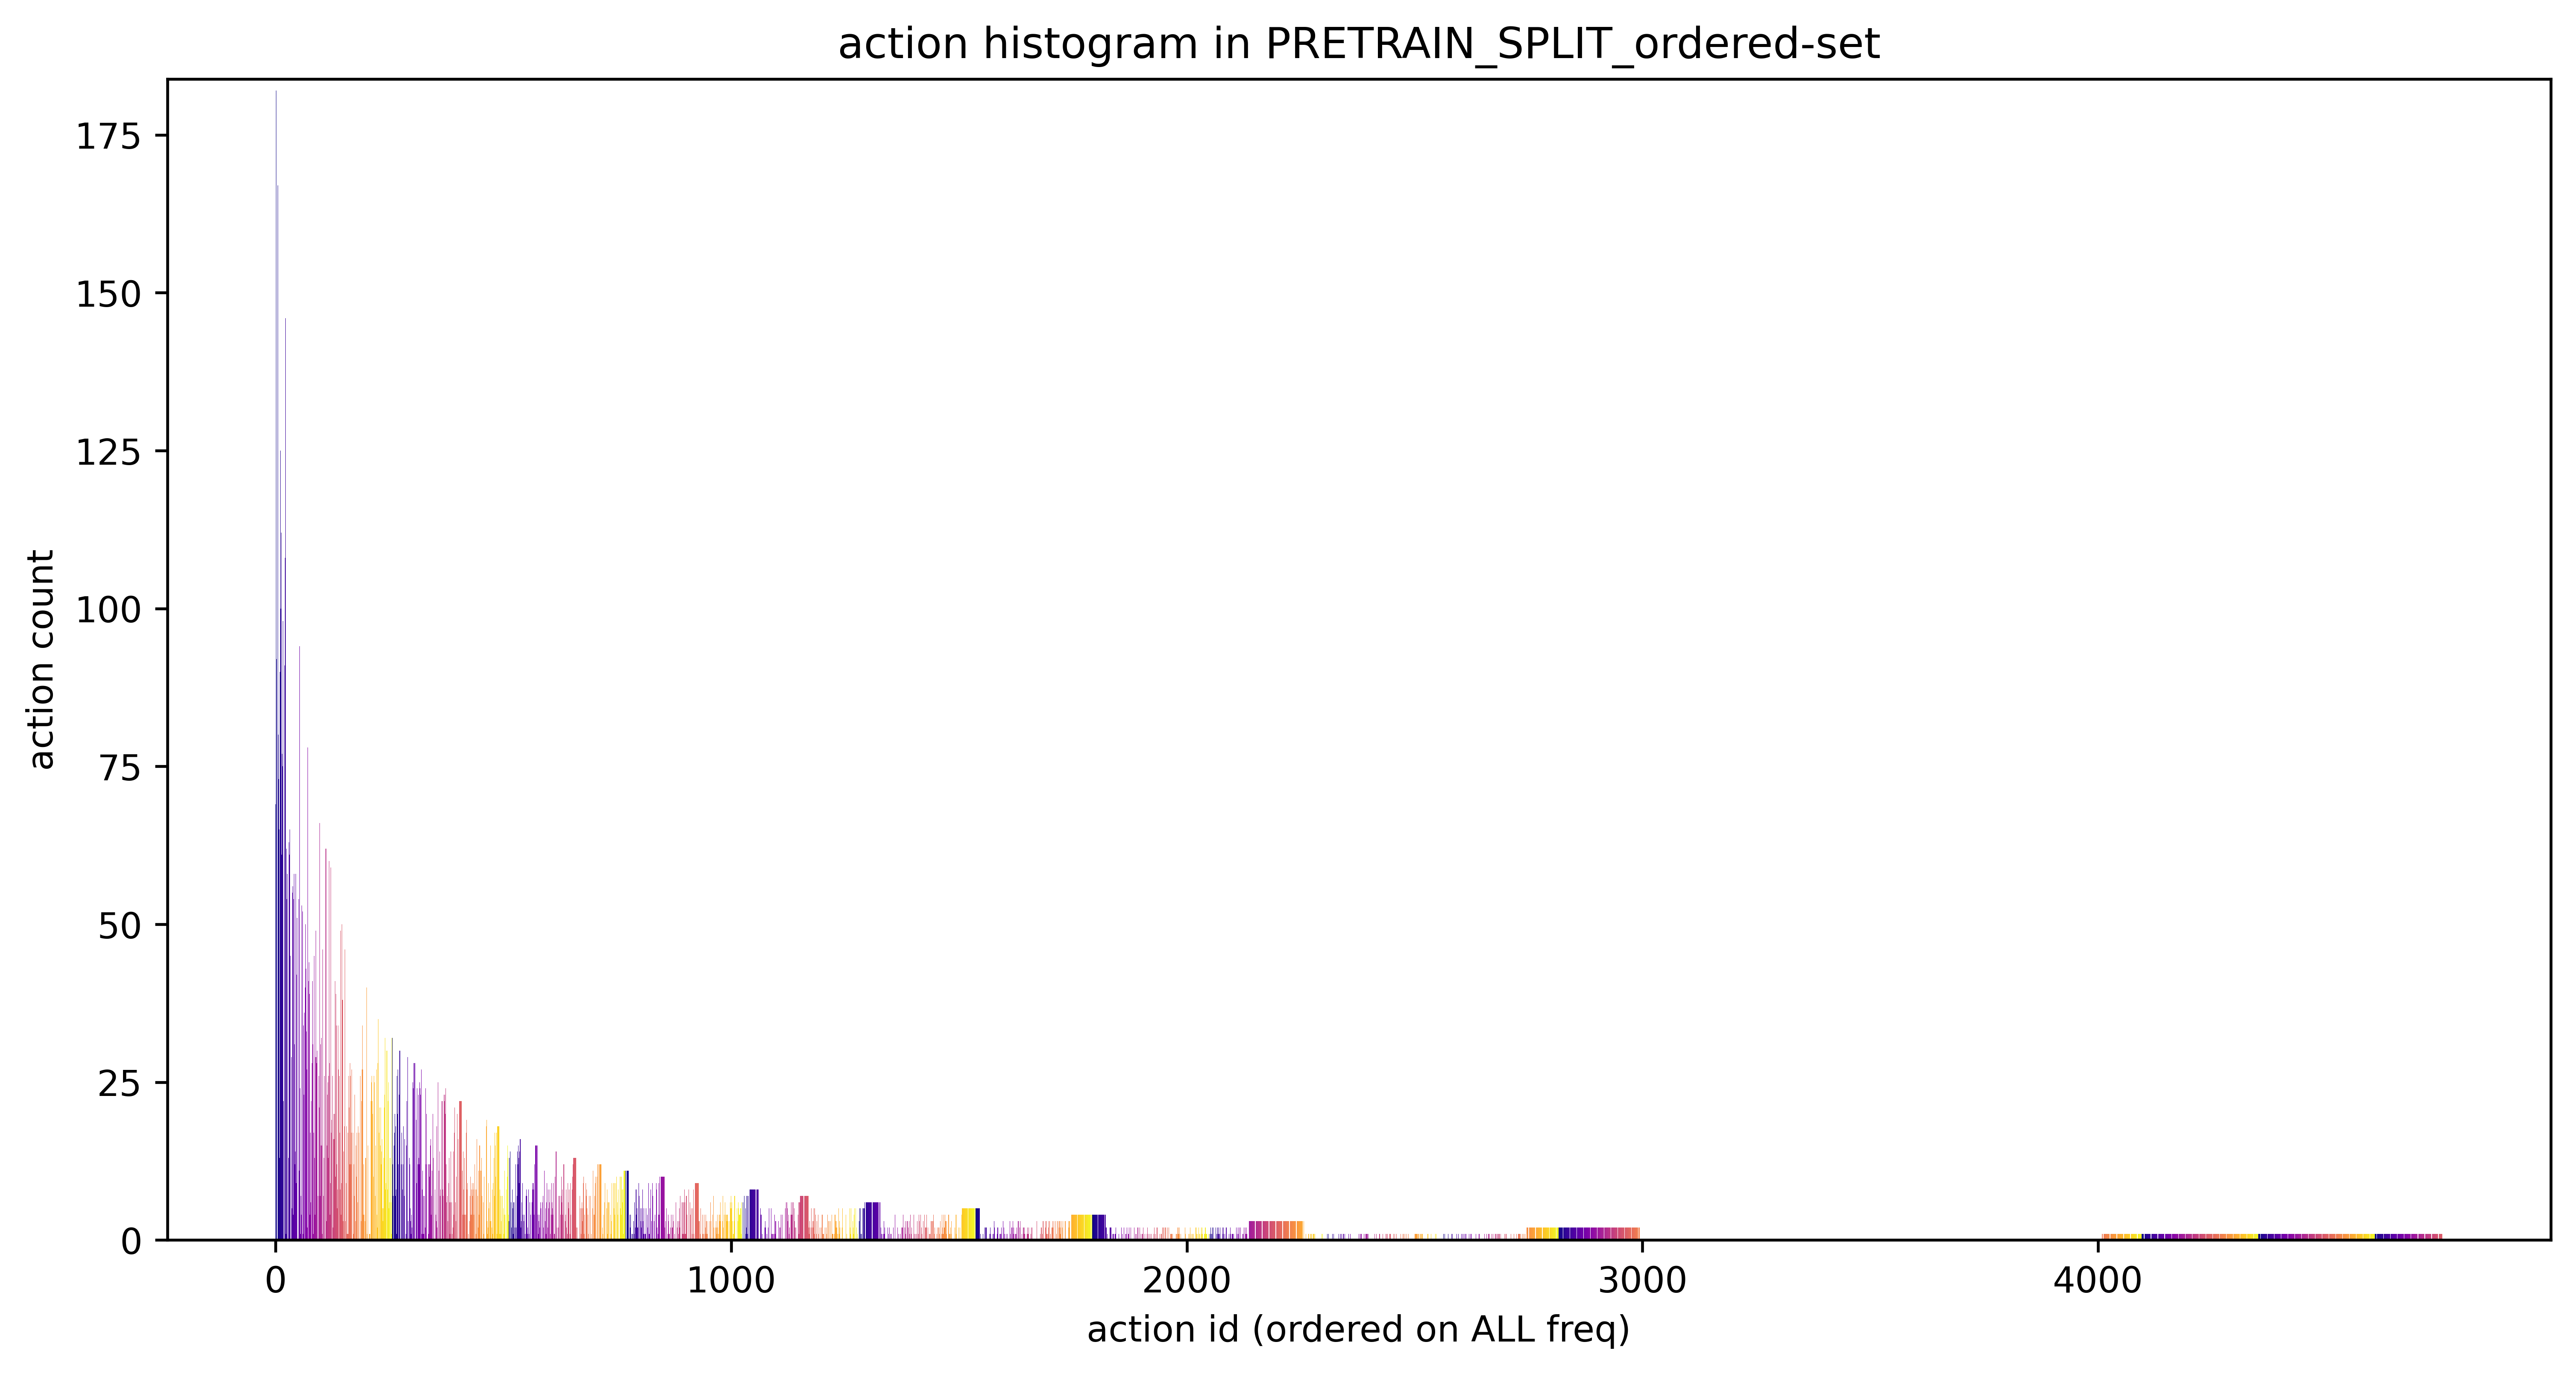

Skipping ALL mode
Skipping TRAIN_SPLIT mode
Skipping TEST_SPLIT mode
Skipping PRETRAIN_SPLIT mode


<Figure size 432x288 with 0 Axes>

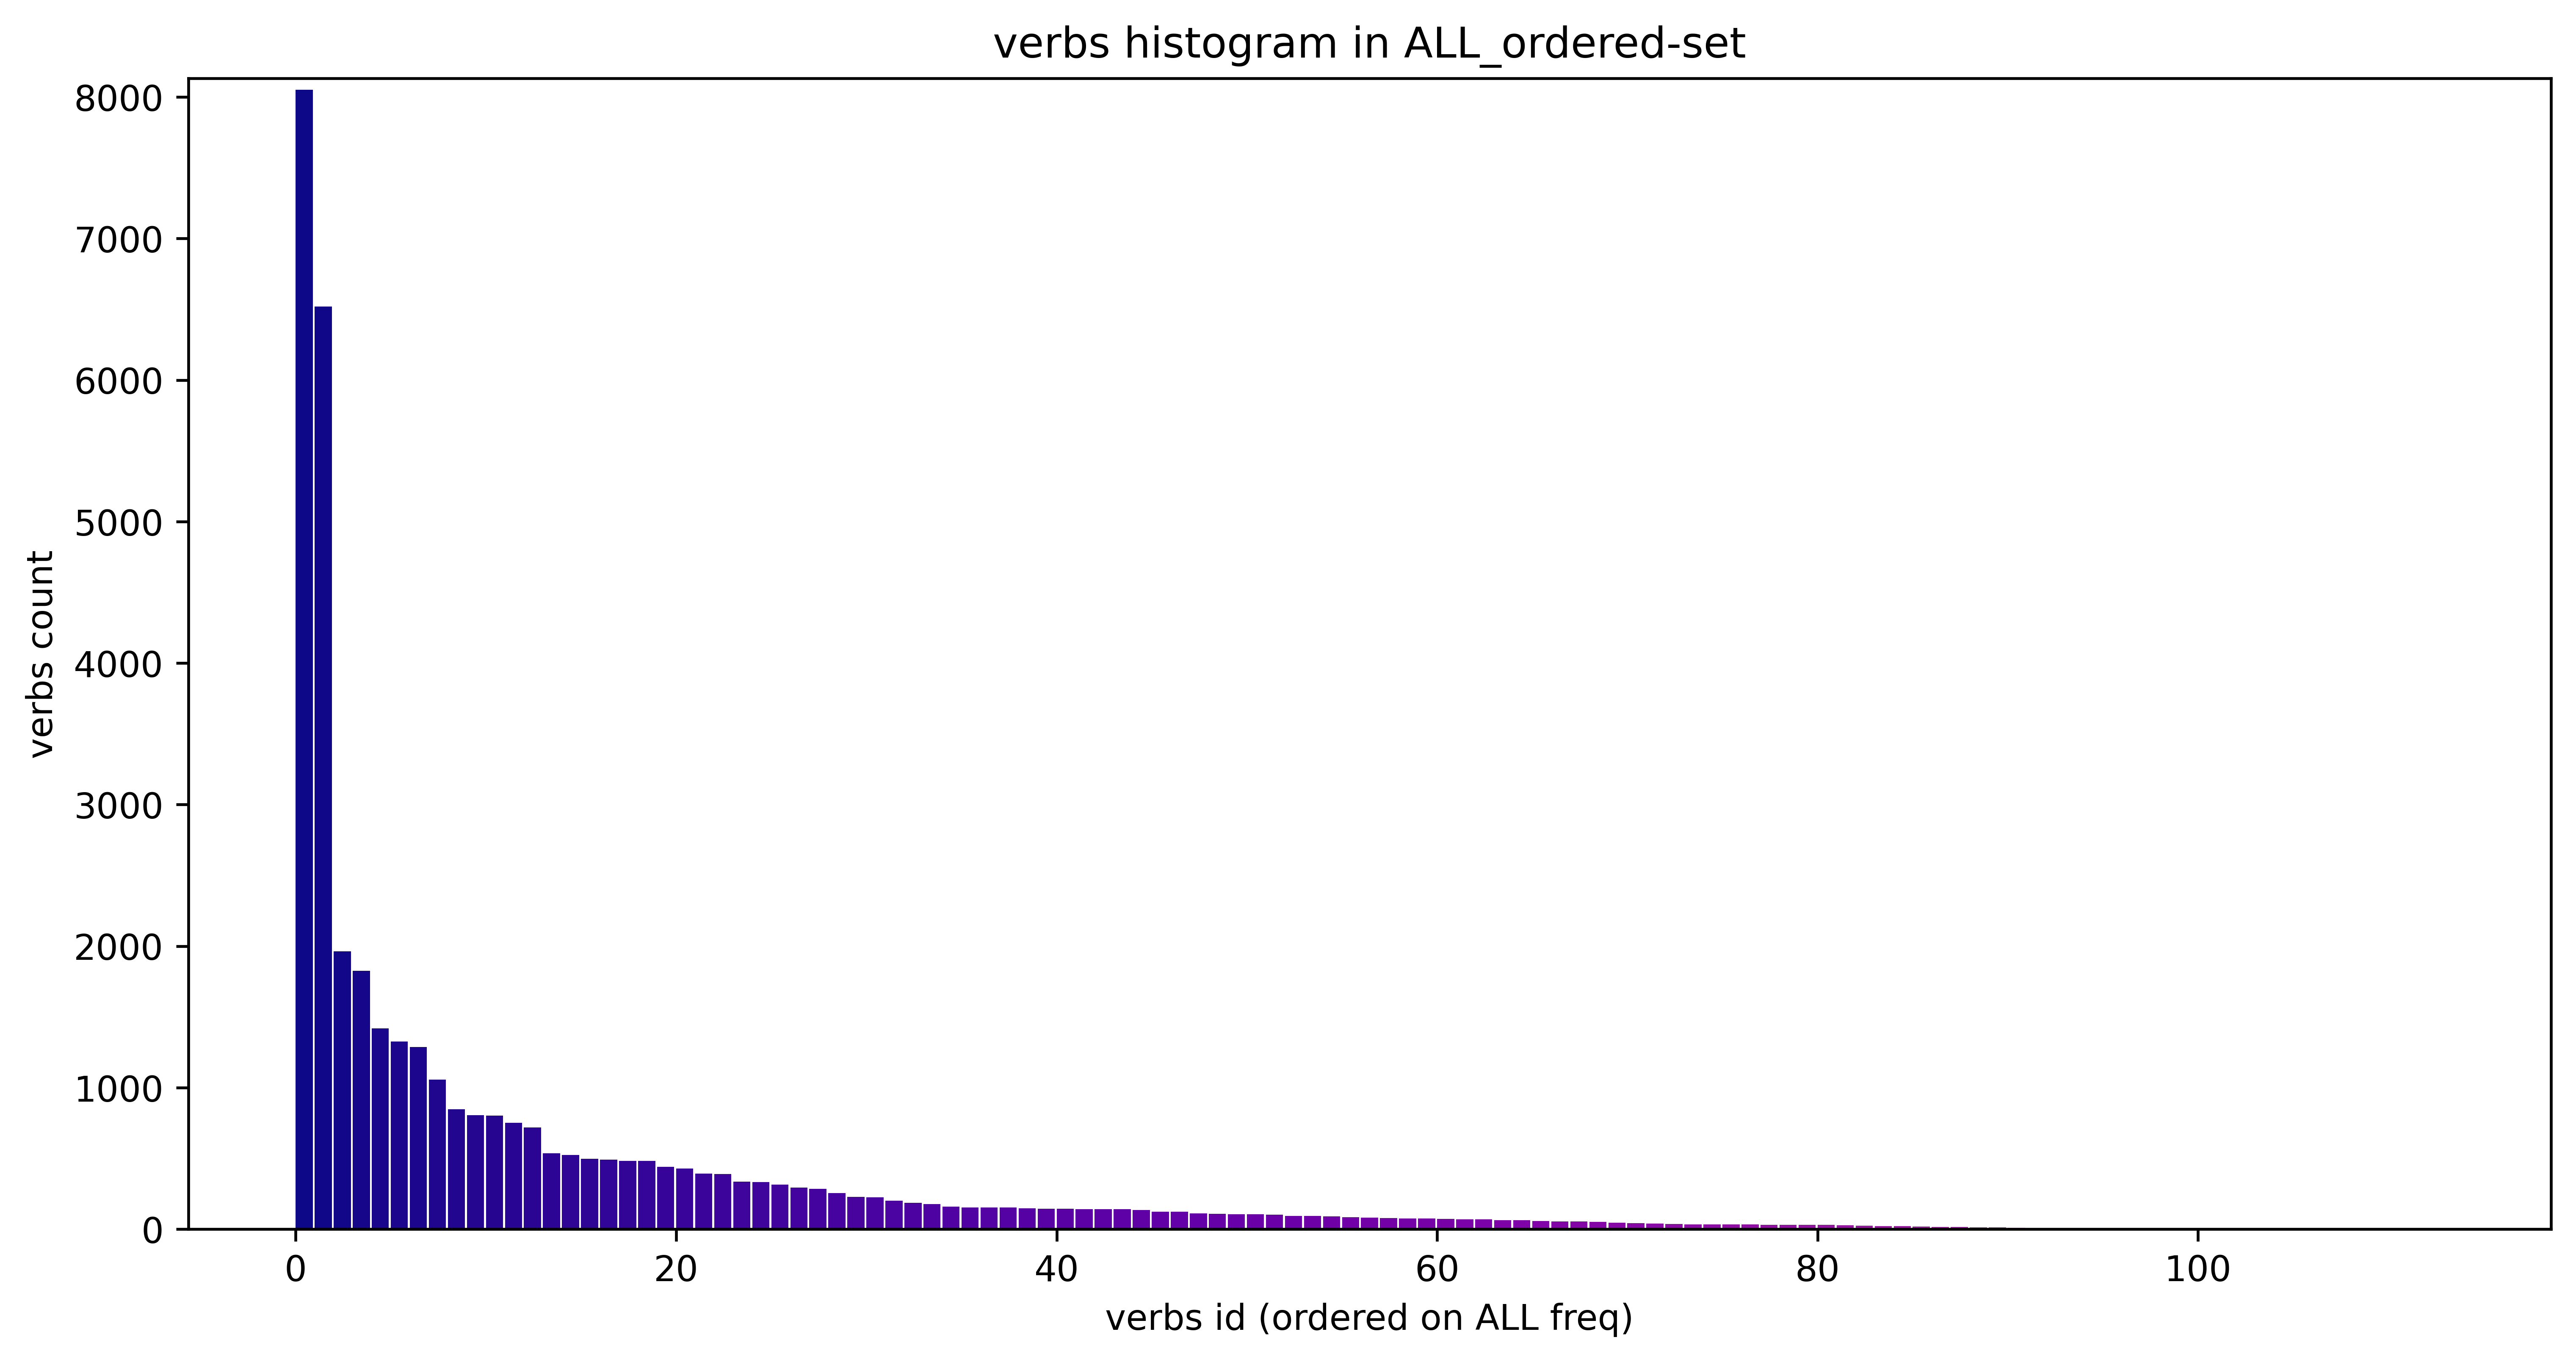

<Figure size 432x288 with 0 Axes>

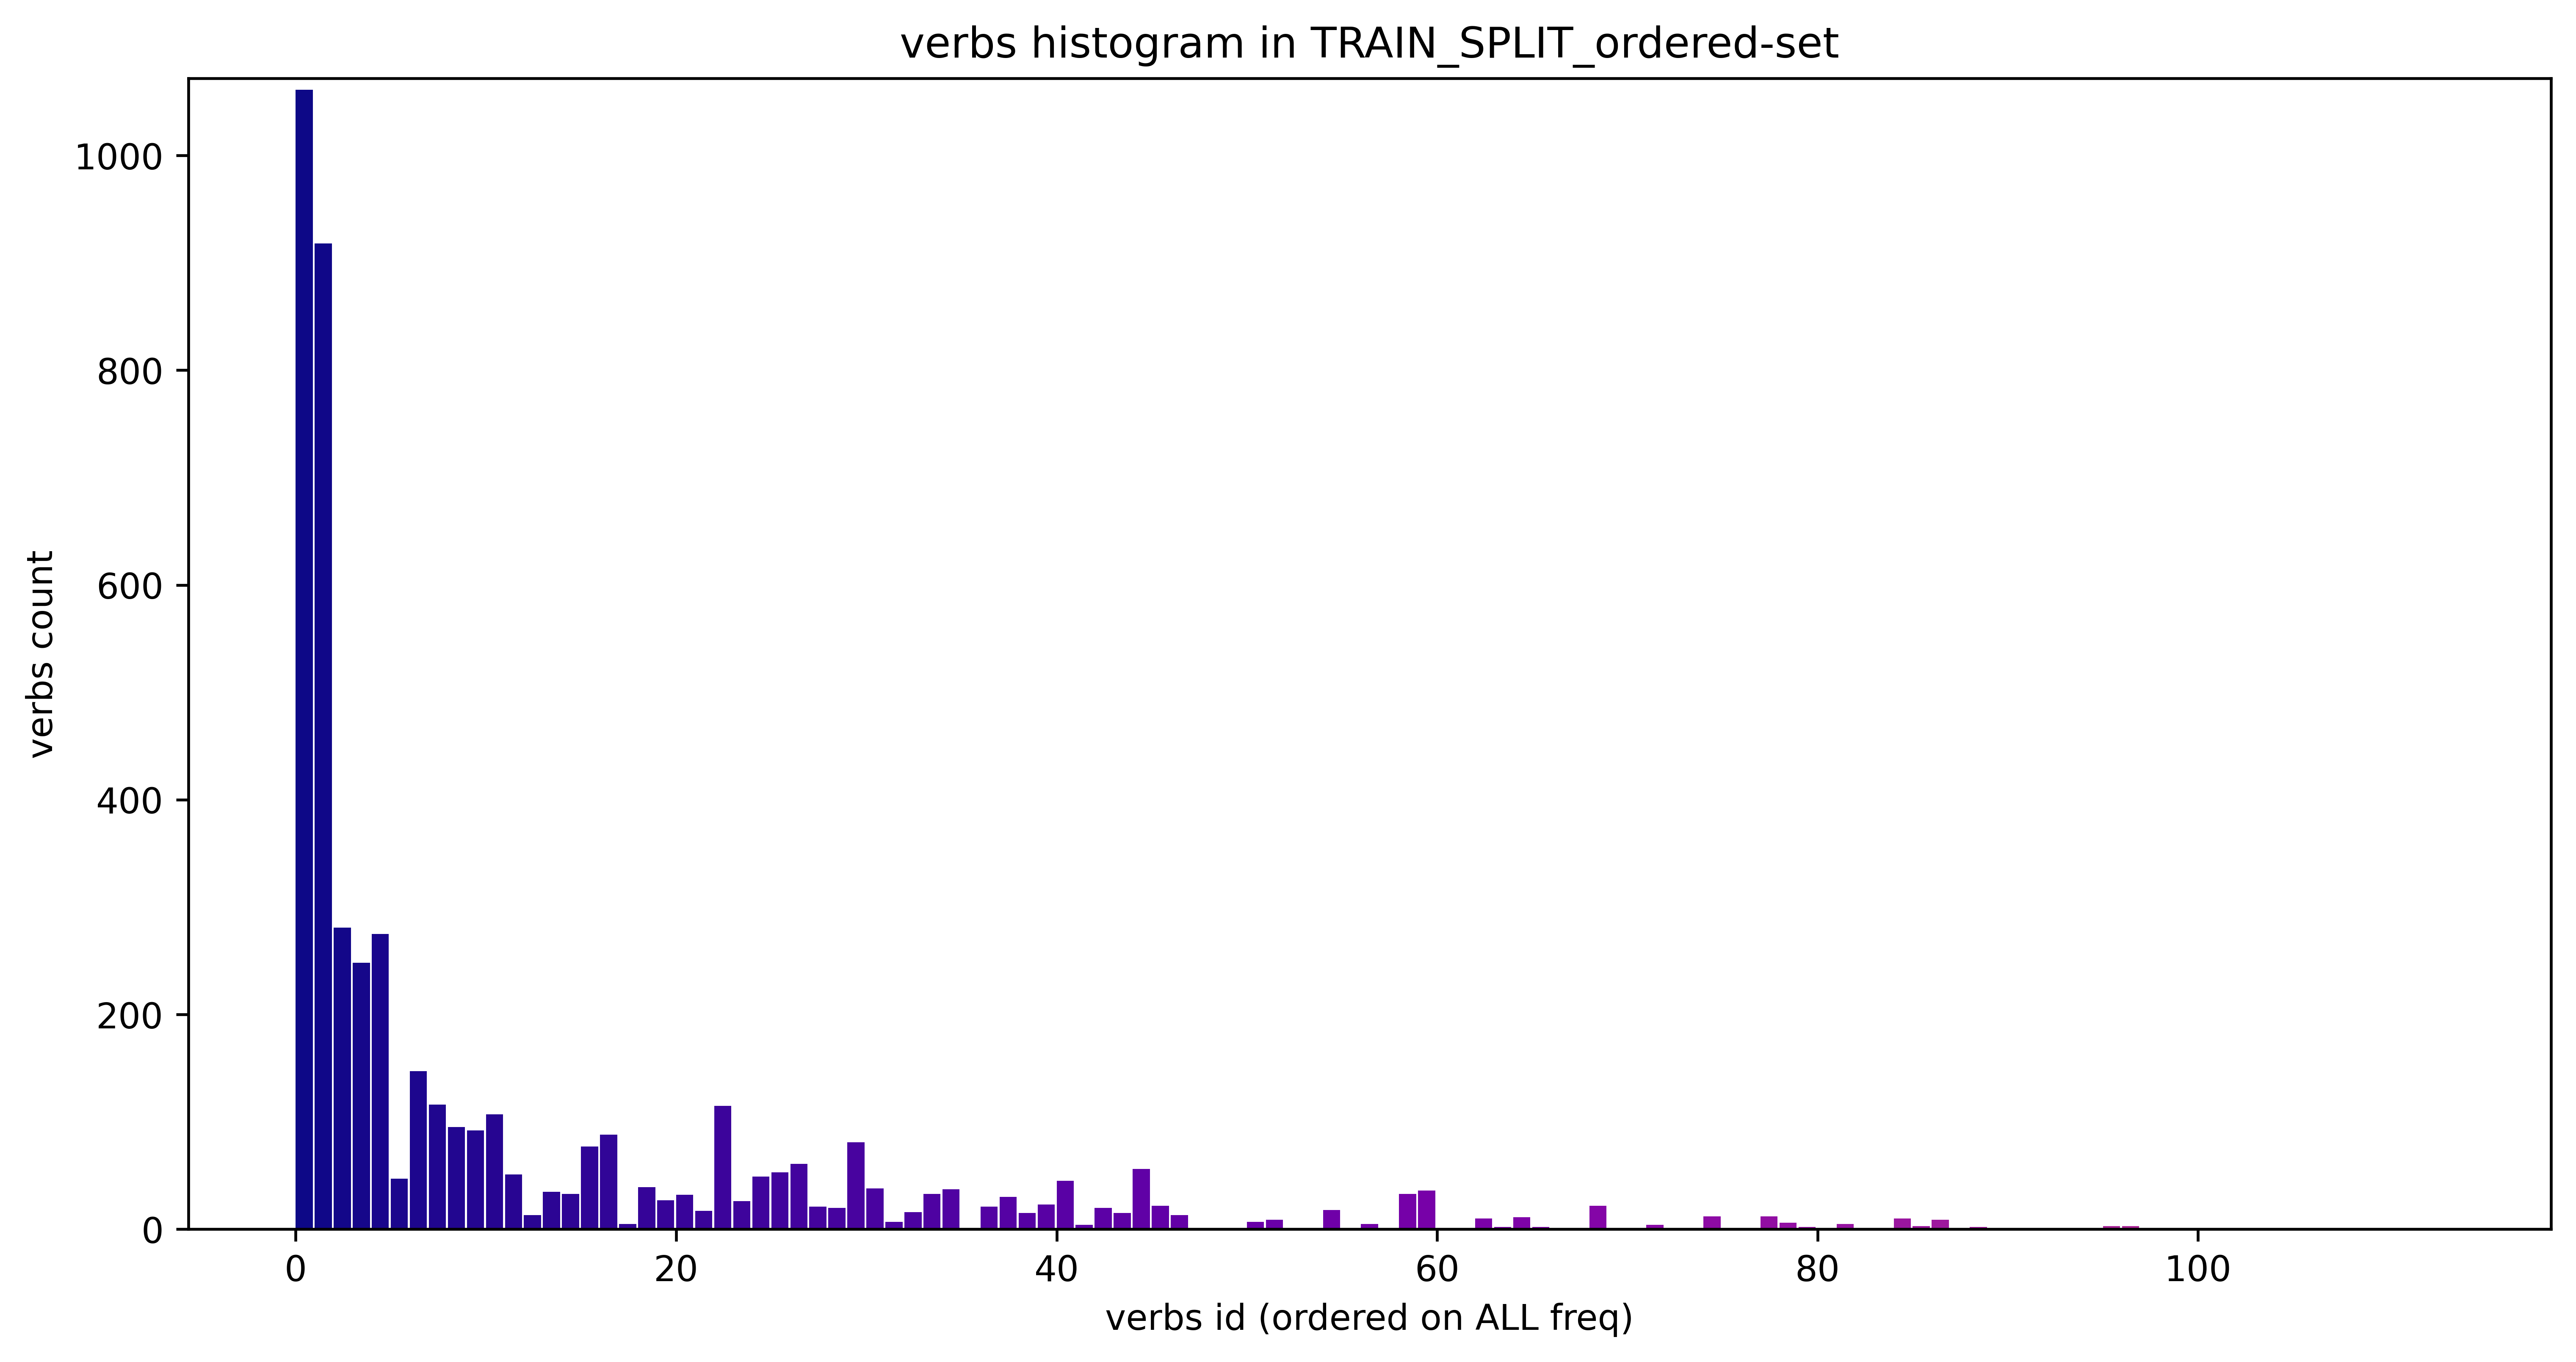

<Figure size 432x288 with 0 Axes>

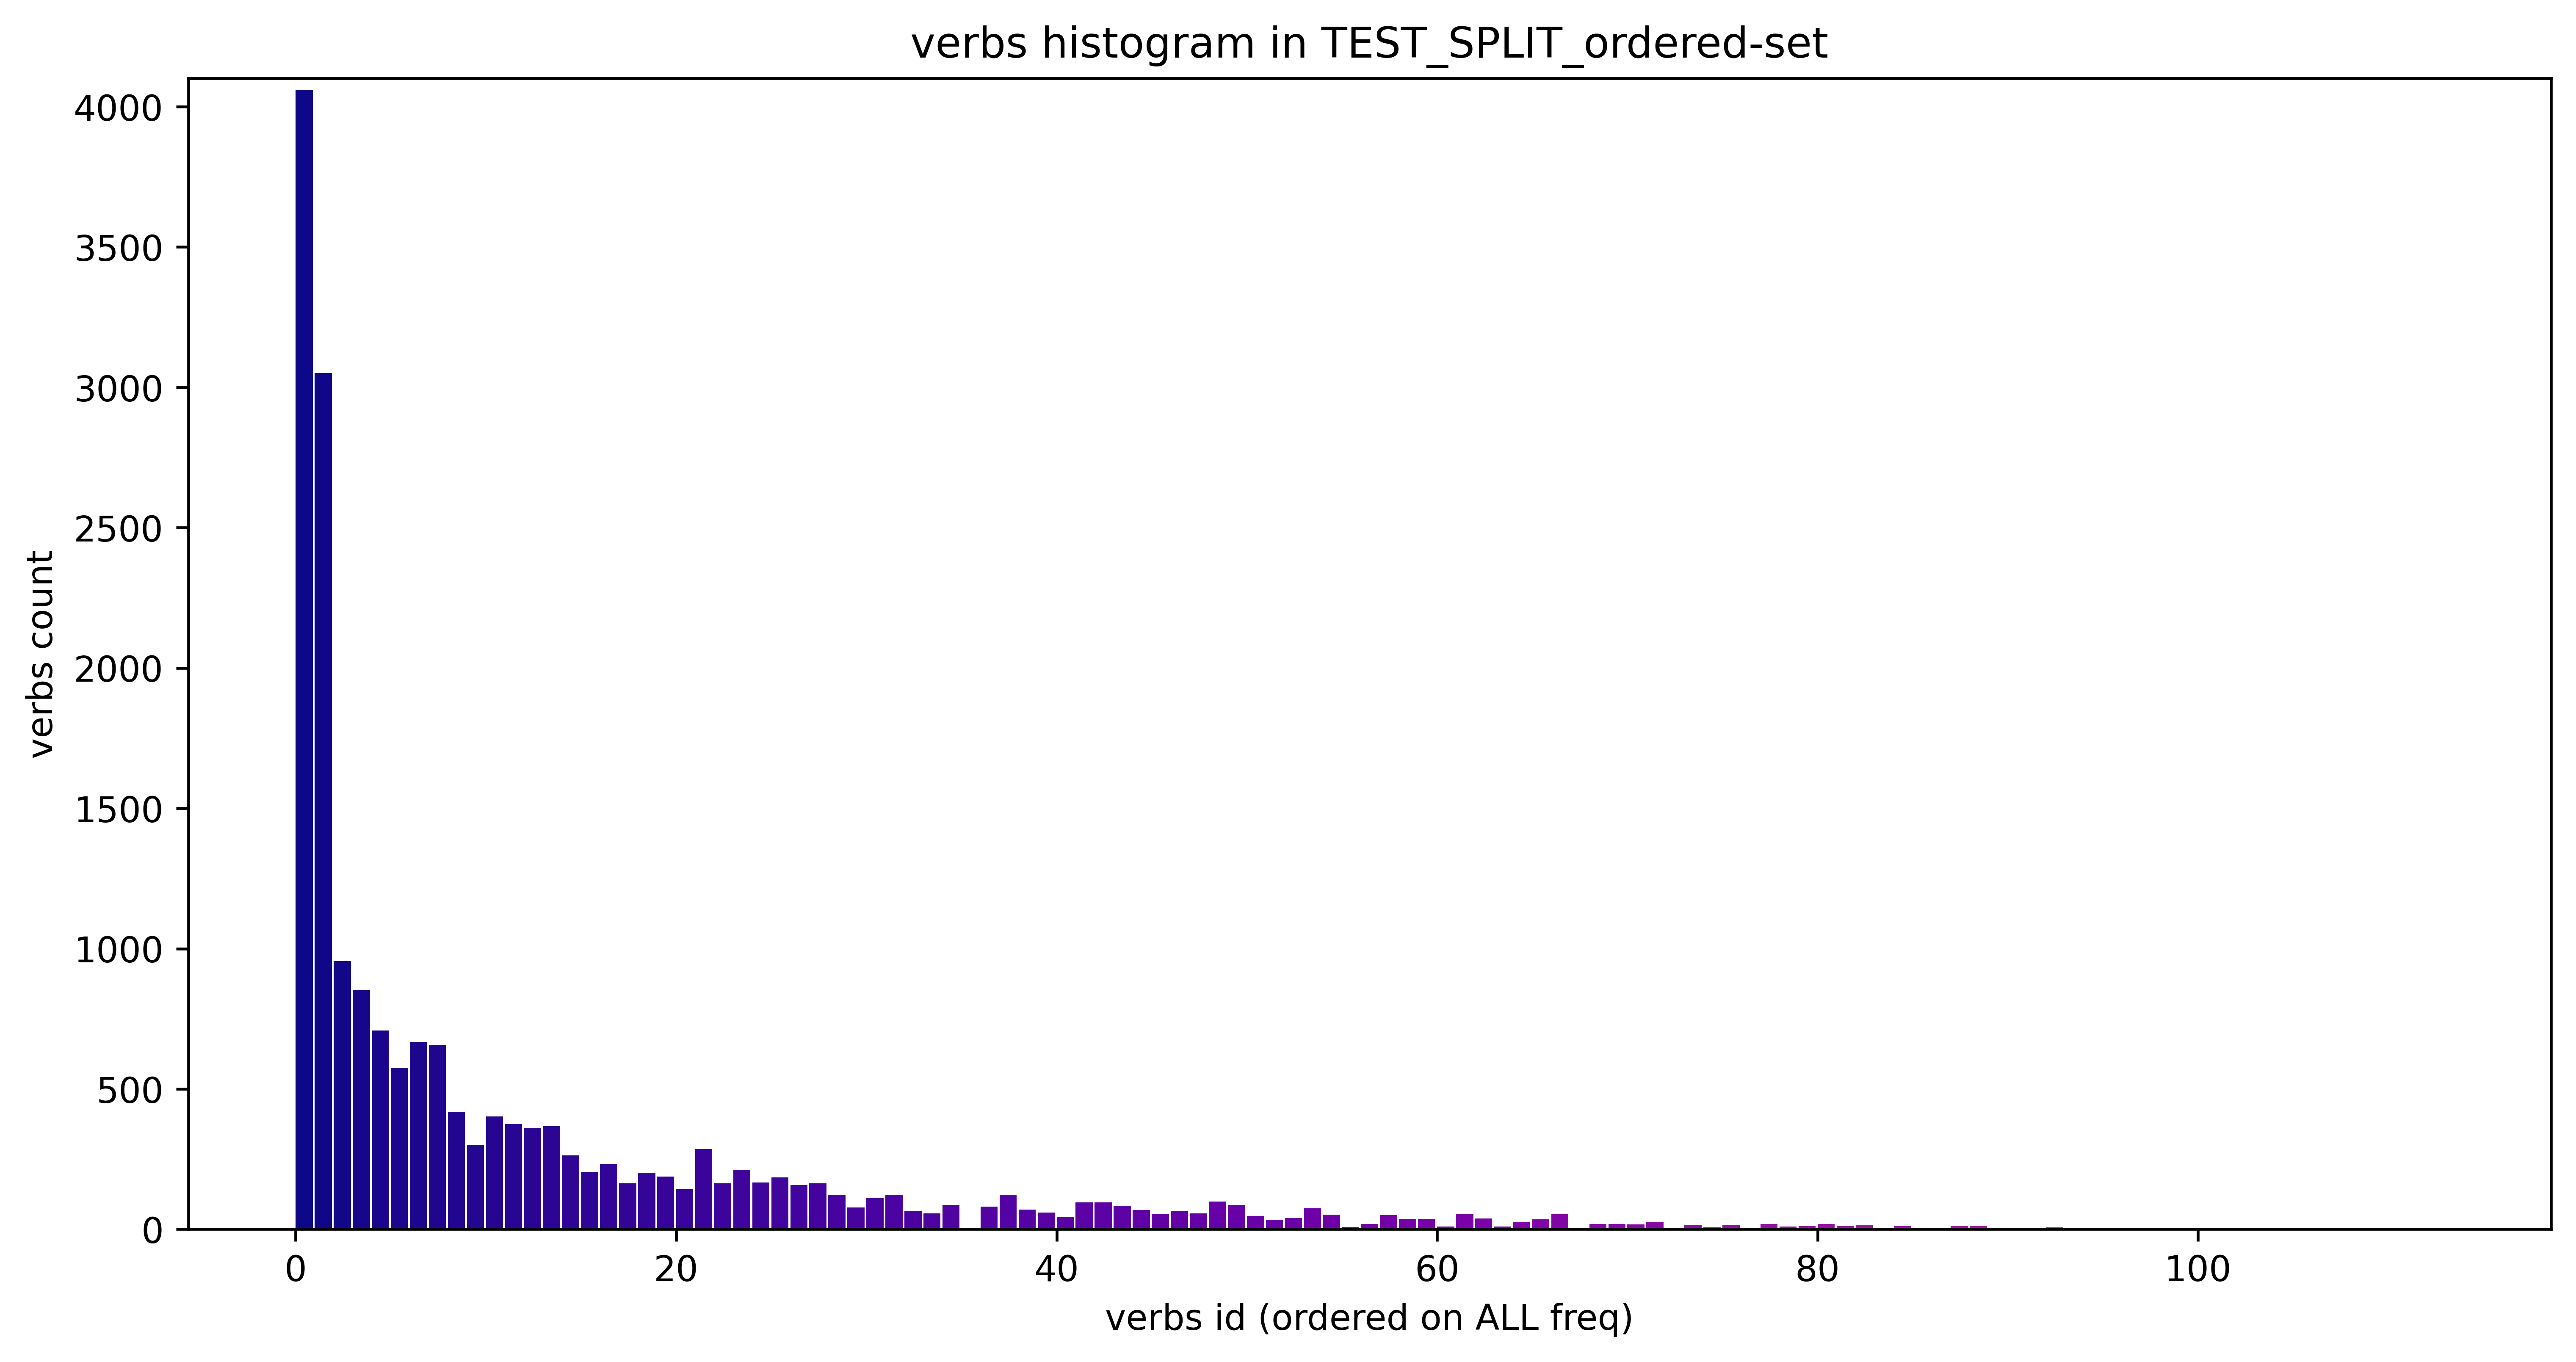

<Figure size 432x288 with 0 Axes>

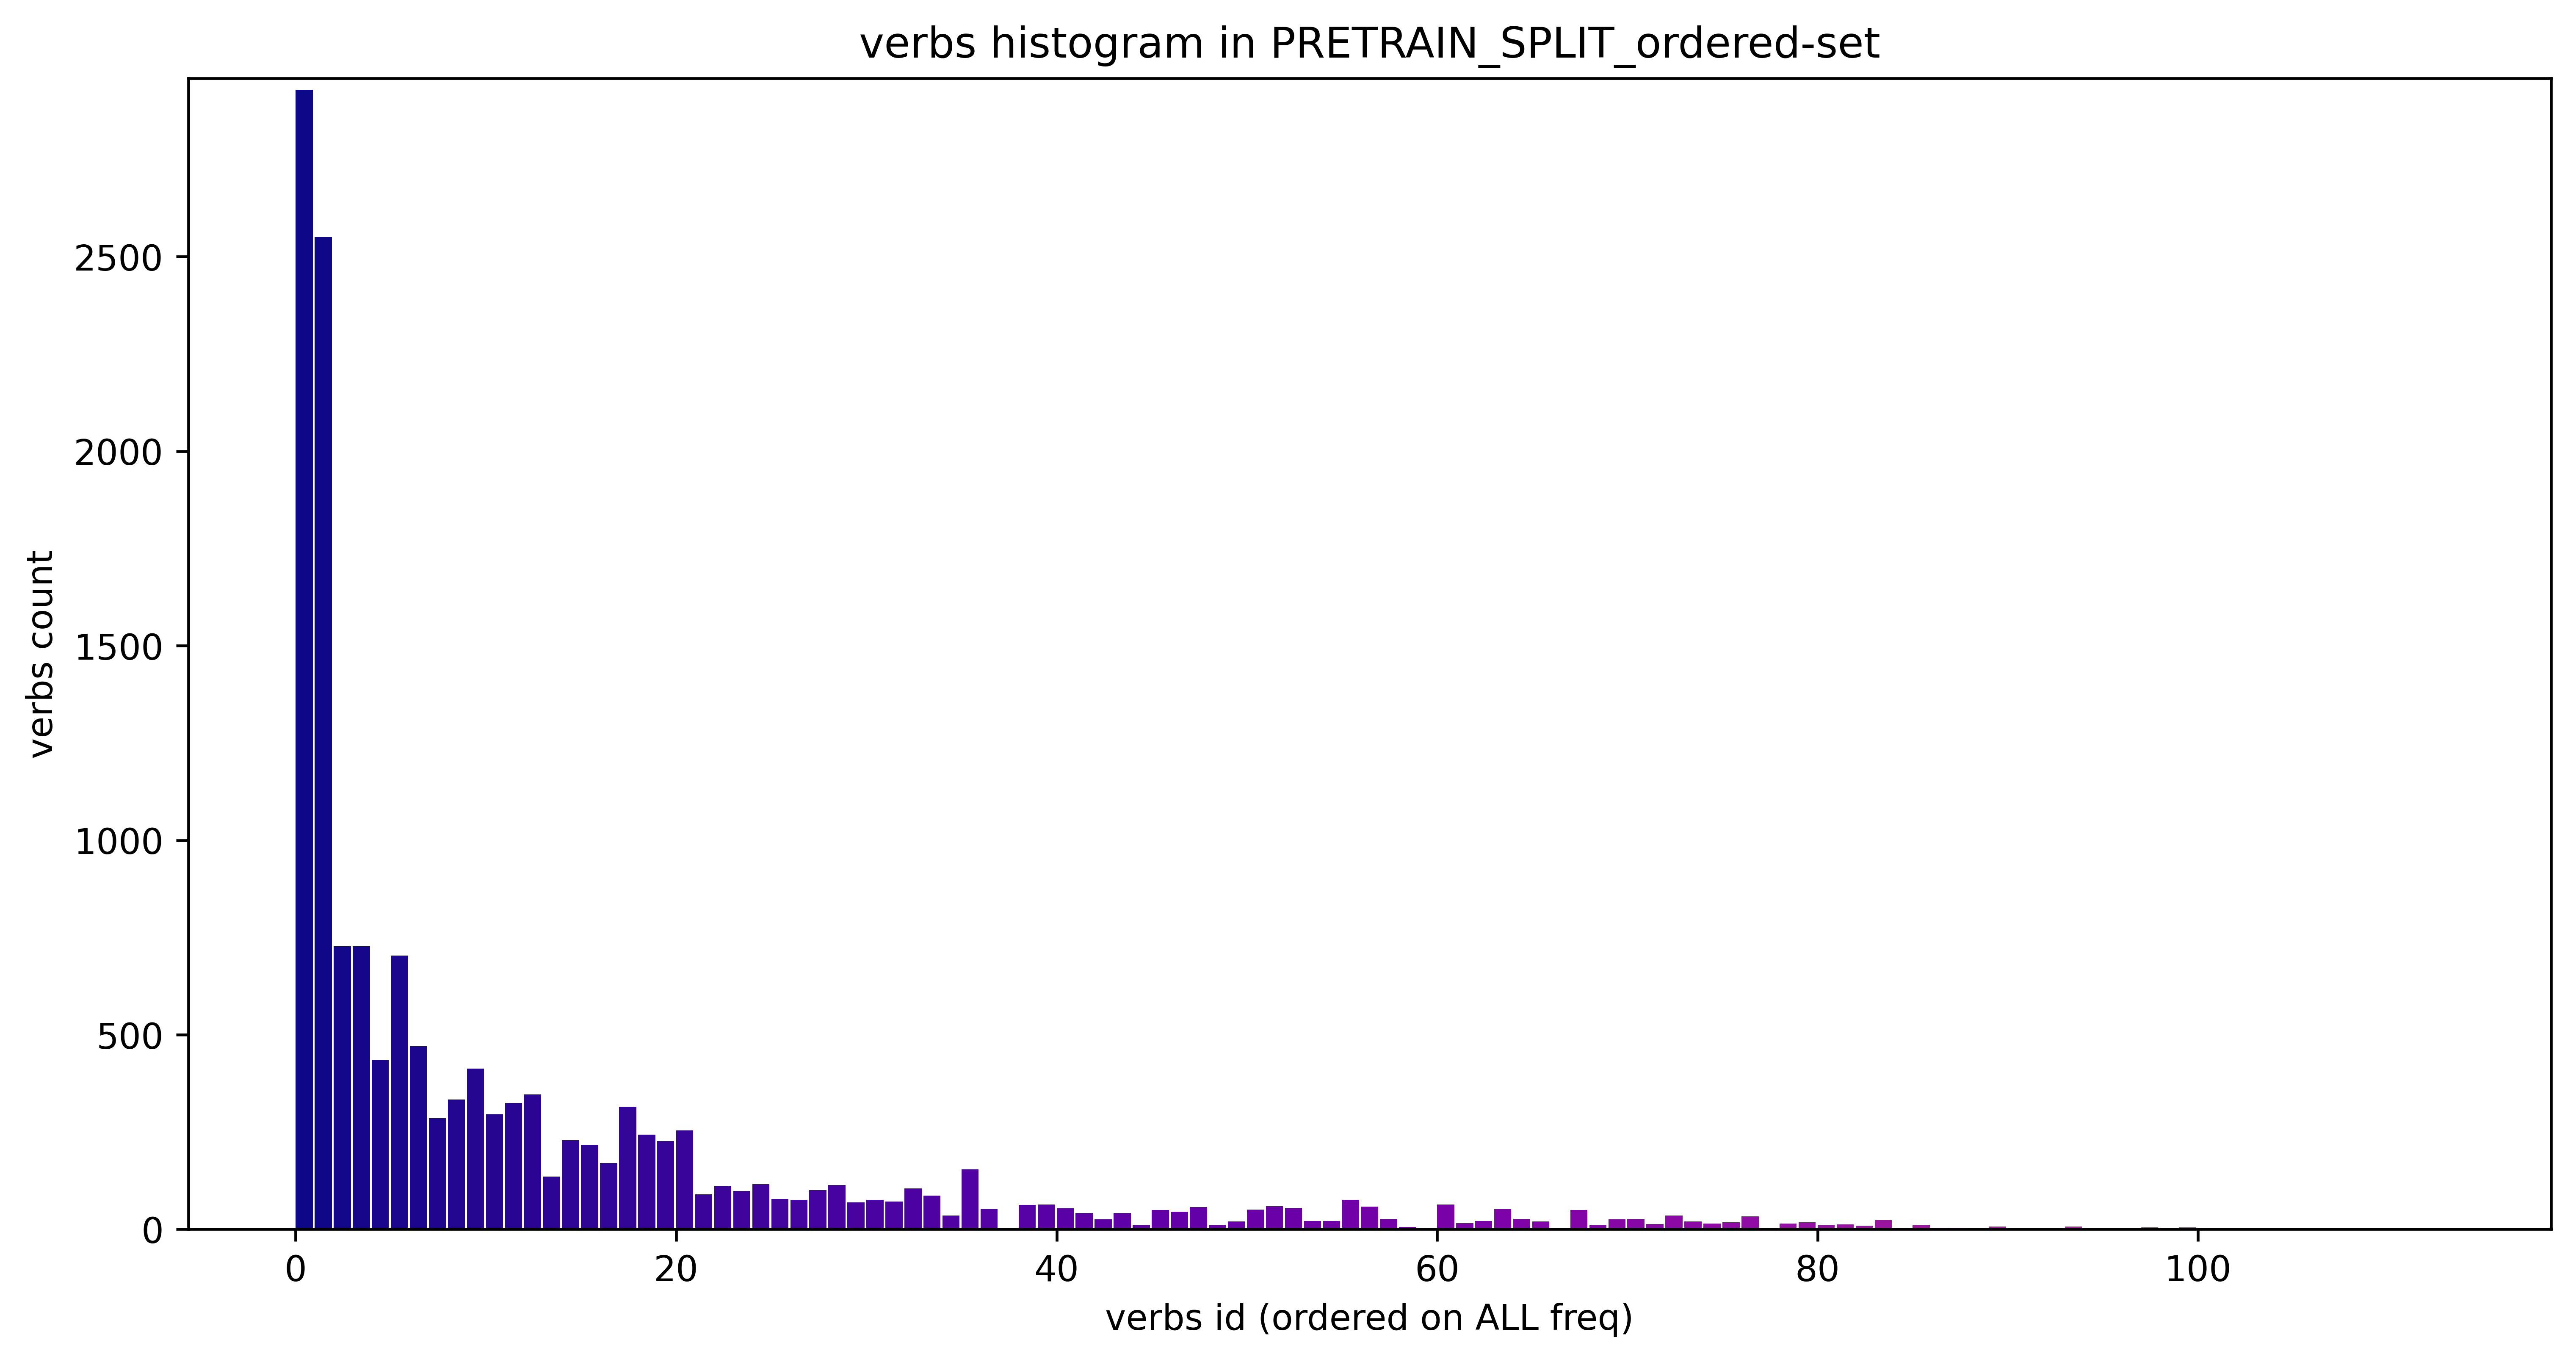

Skipping ALL mode
Skipping TRAIN_SPLIT mode
Skipping TEST_SPLIT mode
Skipping PRETRAIN_SPLIT mode


<Figure size 432x288 with 0 Axes>

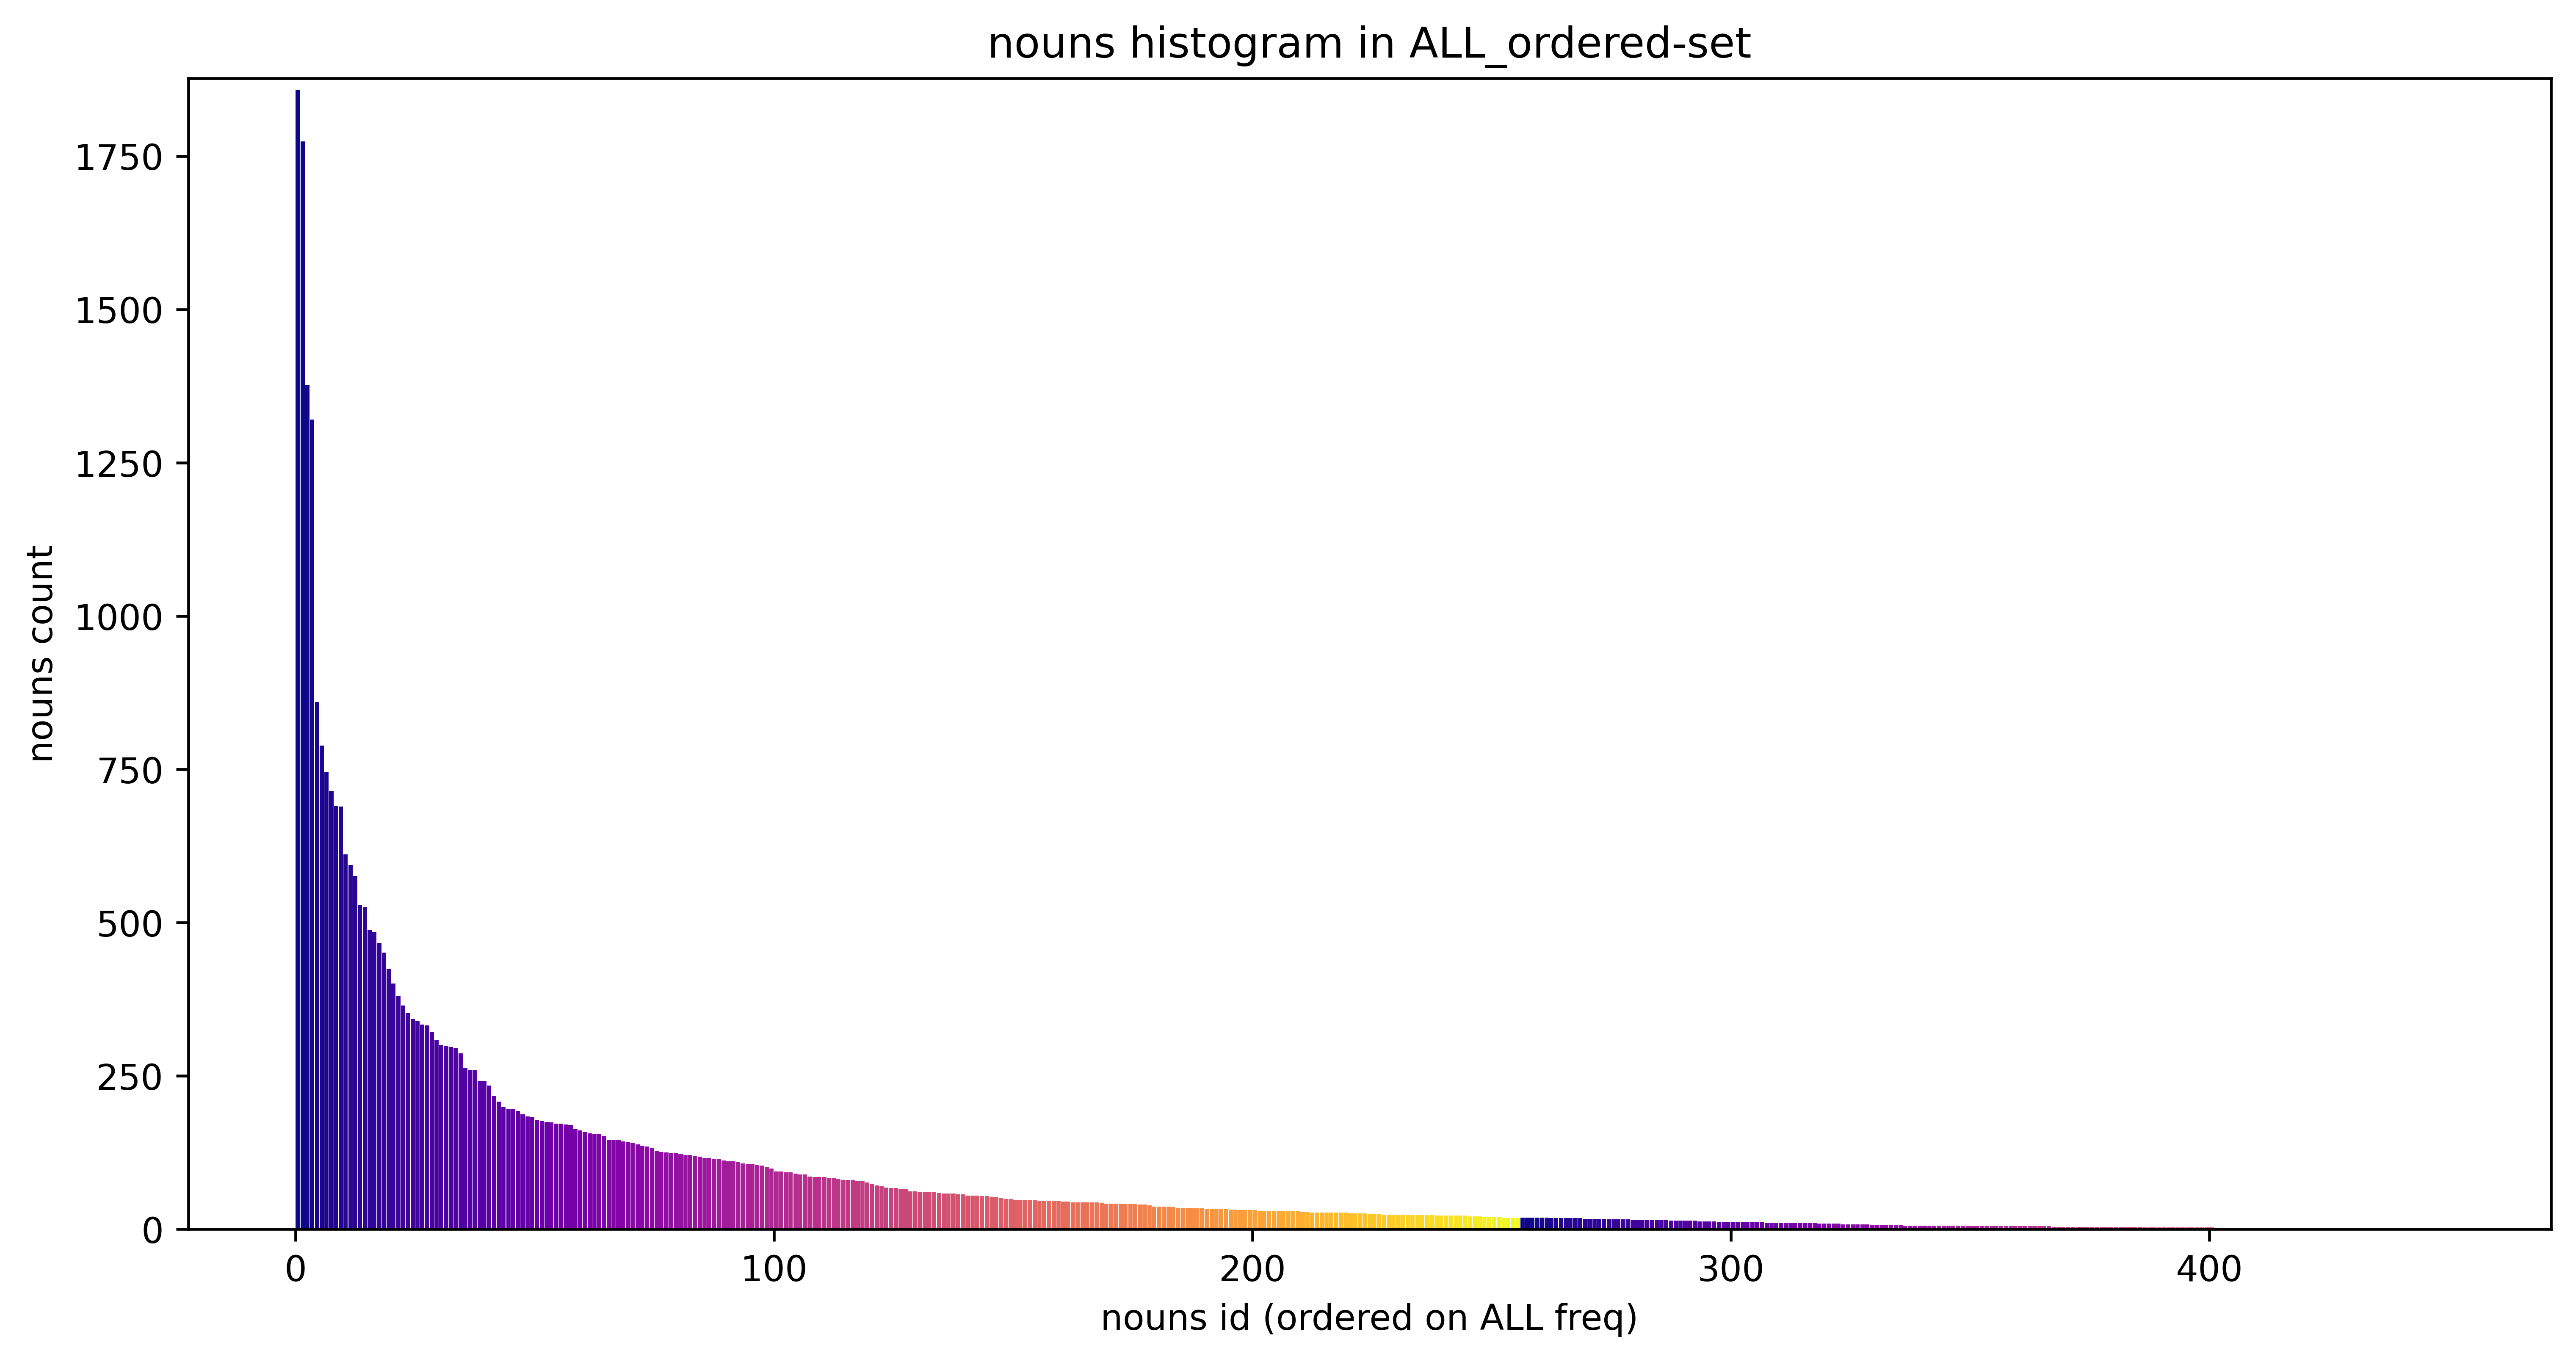

<Figure size 432x288 with 0 Axes>

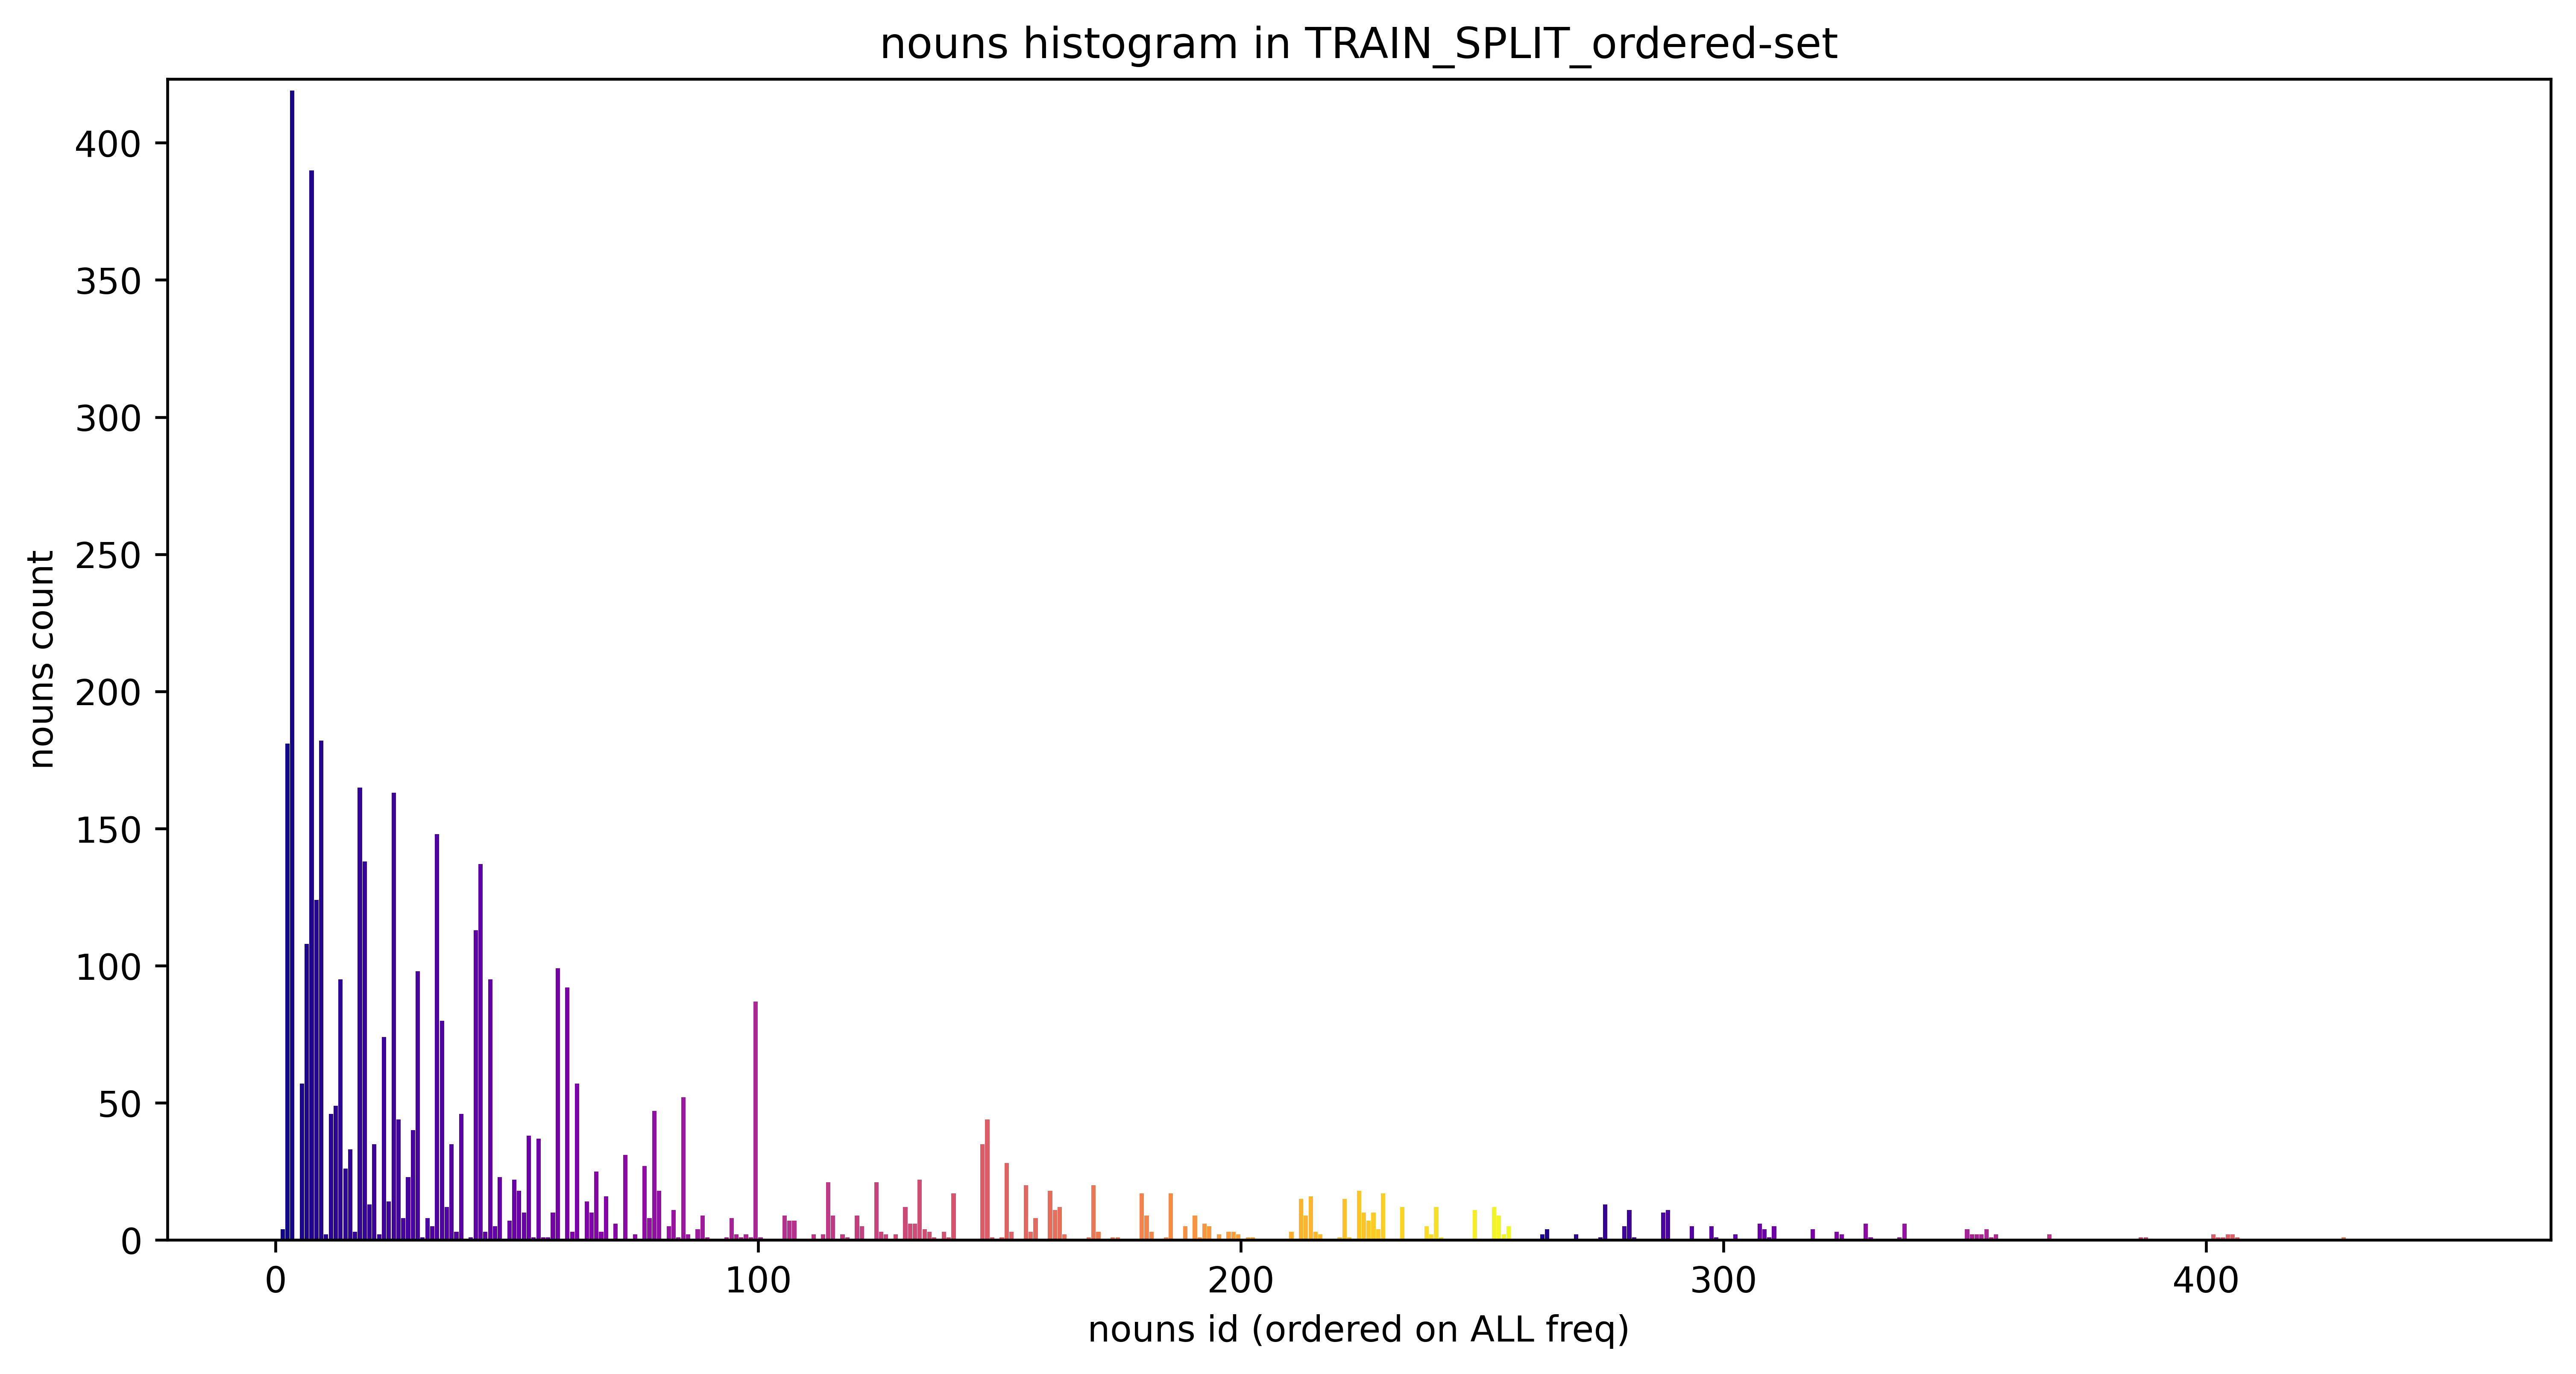

<Figure size 432x288 with 0 Axes>

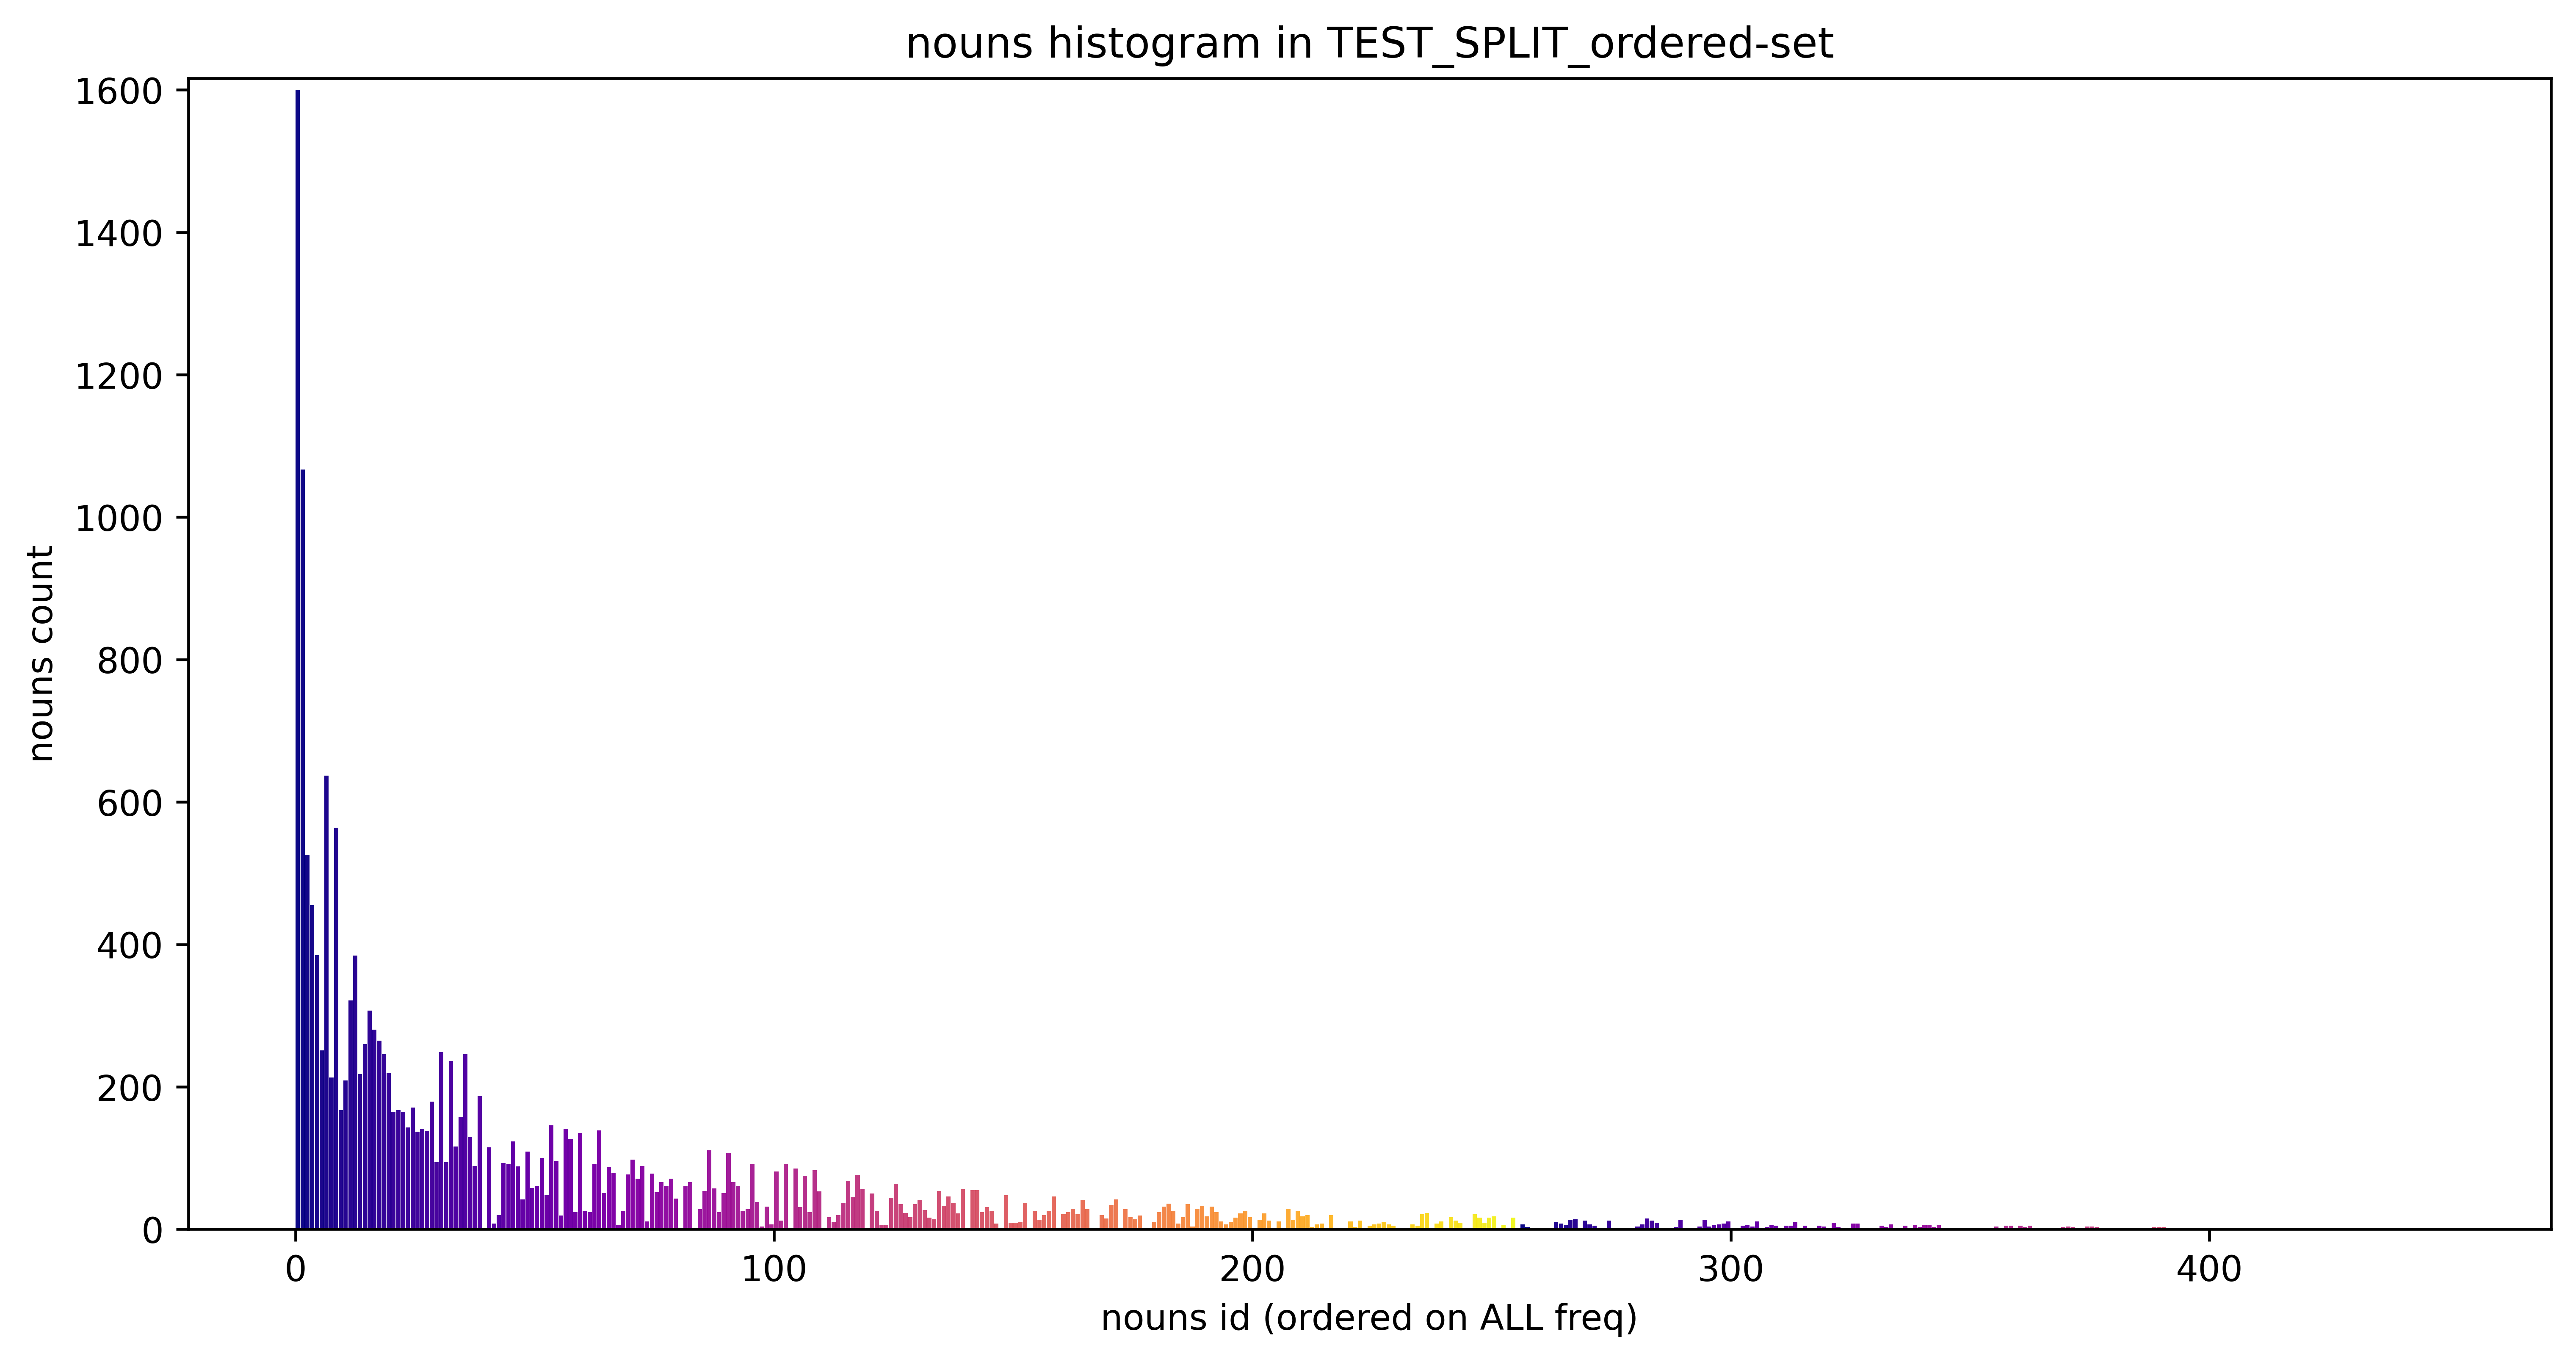

<Figure size 432x288 with 0 Axes>

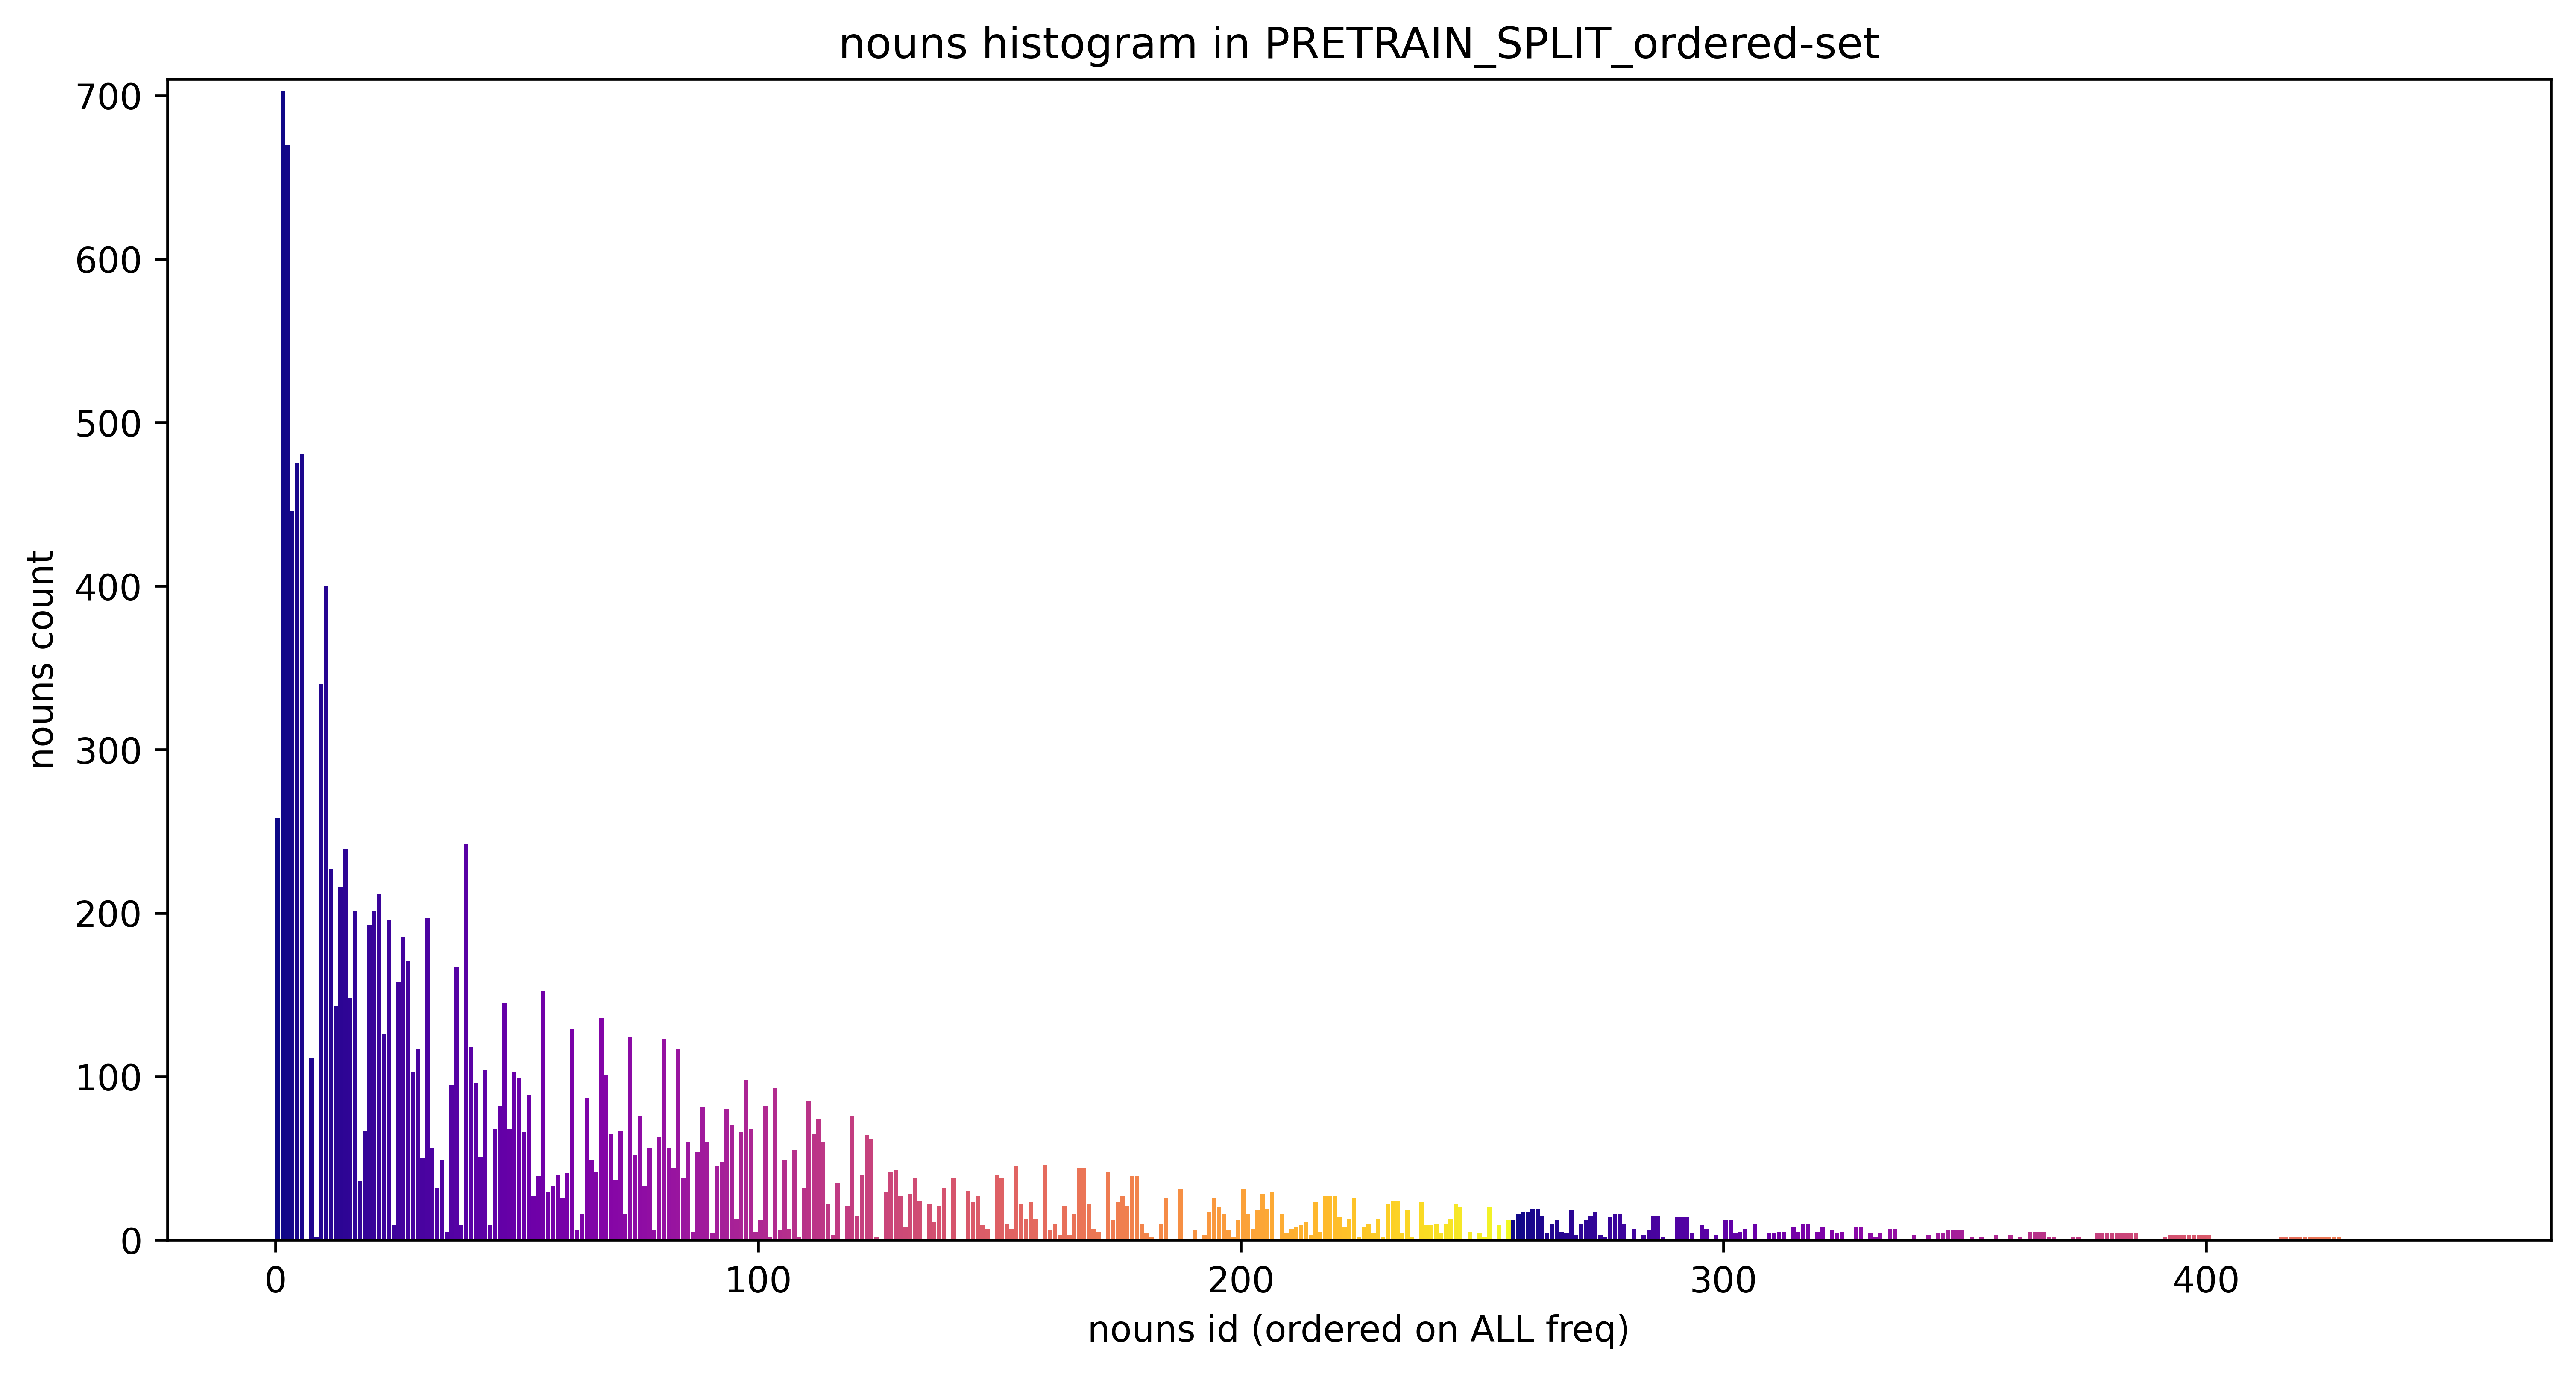

<Figure size 432x288 with 0 Axes>

In [6]:
for action_mode, action_dict in [
('action',ds_counts_actions),
('verbs',ds_counts_verbs),
('nouns',ds_counts_nouns),
]:
    for set_mode, namecount_dict in action_dict.items():
        if 'ordered' not in set_mode:
            print(f"Skipping {set_mode} mode")
            continue
            
        x = list(range(len(namecount_dict['name'])))
        y = namecount_dict['count']
        
        title= f"{action_mode} histogram in {set_mode}-set"
        ylabel= f"{action_mode} count"
        xlabel= f"{action_mode} id (ordered on ALL freq)"
            
        plot_barchart([x],[y],title, ylabel, xlabel)